In [1]:
from src import utils
import numpy as np
import pandas as pd
import dill
from importlib import reload
import shap
from src import constants

2025-08-14 12:55:46.516750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755168946.806714 3171425 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755168946.887401 3171425 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1755168947.188364 3171425 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755168947.188393 3171425 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1755168947.188395 3171425 computation_placer.cc:177] computation placer alr

In [3]:
angle_columns_291 = list(constants.angle_columns_291.values())  # list of indices
not_angle_columns_291 = list(constants.not_angle_columns_291.values())  # list of indices

In [2]:
from src import utils, constants
import numpy as np
import pandas as pd
import dill
with open('/scratch-scc/users/u14286/piplines/Bind/tmp/AF-Q9VT52-F1-model_v4.dill', 'rb') as f:
    data = dill.load(f)

In [ ]:



tfmanager = utils.TFRecordManager(tfrecord_path='tmp/test.tfrecord', feature_dim=86)
tfmanager.write_samples(features=arr, labels=labels_arr, ID_arrs=IDs)
train_ds = tfmanager.read_dataset()

In [ ]:

from src import utils
import numpy as np
import pandas as pd
import dill
from importlib import reload
import time
reload(utils)

s = time.time()
output = utils.Extract_and_Save_from_PDB(input_file='/scratch-scc/users/u14286/piplines/Bind/data/large/alphafold_db/test_data/AF-Q9VT52-F1-model_v4.pdb',
                                 from_dill=False,
                                saving_dir='tmp/', k_nearest=5, inteacting_residues=False,
                              un_dn=False, outtype='tfrecord', save_file=False)

print(time.time() - s)
features, labels_arr, IDs, columns, plddt_arr = output


#### 1- Extract for id AF-Q9VT52-F1-model_v4
PDB State AF-Q9VT52-F1-model_v4
#### 3- Structure cleaned and renumbered AF-Q9VT52-F1-model_v4
Append time: 2.384185791015625e-07 Iter time: 0.0010123252868652344 Before centroid calc: 0.0009169578552246094 SASA time: 2.1457672119140625e-06
#### 4- pdb to df done AF-Q9VT52-F1-model_v4
################SIDE (120, 3)


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x1552e5471f10>>
Traceback (most recent call last):
  File "/user/a.hajialiasgarynaj01/u14286/miniforge3/envs/Bind/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 781, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [ ]:
tfmanager = utils.TFRecordManager(tfrecord_path='tmp/test2.tfrecord', feature_dim=86)
tfmanager.write_samples(features=features, labels=labels_arr, ID_arrs=IDs, plddt=plddt_arr)
train_ds = tfmanager.read_dataset()

In [101]:
import tensorflow as tf
import keras
from keras import layers

class RandomMasking(layers.Layer):
    def __init__(self, mask_ratio=0.20, **kwargs):
        super(RandomMasking, self).__init__(**kwargs)
        self.mask_ratio = mask_ratio
        assert 0 < self.mask_ratio < 1, "mask_ratio must be between 0 and 1"

    def call(self, inputs, training=True):
        if training:
            inputs = tf.random.normal(shape=(5, 5))  # Example input tensor
            mask = tf.random.uniform(tf.shape(inputs), minval=0, maxval=1, dtype=tf.float32)
            mask = tf.cast(mask < self.mask_ratio, dtype=tf.float32)  
            inputs = inputs * (1 - mask)   # Apply mask
        else:
            inputs = inputs
        # Return the masked inputs
        # If not training, return inputs unchanged
        return inputs

    def get_config(self):
        config = super(RandomMasking, self).get_config()
        config.update({"mask_ratio": self.mask_ratio})
        return config


class Sampling(layers.Layer):
    def __init__(self, name='samplig', **kwargs):
        super(Sampling, self).__init__(**kwargs)

    def call(self, inputs): #Z=(N,dim), Var=(N,dim)
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

    def get_config(self):
        return super(Sampling, self).get_config()
    


def create_model_vae_plddt(input_shape, mask_ratio=0.20, num_layers=3, 
                            layer_dims=[512, 256, 128], latent_dim=128):
    # Encoder model
    fetures_inp = layers.Input(shape=input_shape, name='features_input')
    x = RandomMasking(mask_ratio=mask_ratio)(fetures_inp)
    for i in range(num_layers):
        x = layers.Dense(layer_dims[i], activation='relu', name=f'encoder_dense_{i}')(x)
    z_mean = layers.Dense(latent_dim, name='z_mean')(x)
    z_log_var = layers.Dense(latent_dim, name='z_log_var')(x)
    z = Sampling()([z_mean, z_log_var])
    #Decoder model
    y = layers.Dense(layer_dims[-1], activation='relu', name='decoder_dense_0')(z)
    for i in range(1, num_layers):
        y = layers.Dense(layer_dims[-i-1], activation='relu', name=f'decoder_dense_{i}')(y)
    plddt_out = layers.Dense(32, activation='relu', name='plddt_1')(z)
    plddt_out = layers.Dense(1, name='plddt_output')(plddt_out)
    features_out = layers.Dense(input_shape[-1], name='features_output')(y)
    encoder = keras.Model(fetures_inp, [z_mean, z_log_var, z], name='encoder')
    decoder = keras.Model(z, features_out, name='decoder')
    plddt_model = keras.Model(z, plddt_out, name='plddt_model')
    return encoder, decoder, plddt_model

In [ ]:
encoder, decoder, plddt_model = create_model_vae_plddt(input_shape=(301,), mask_ratio=0.20, num_layers=3, 
                            layer_dims=[512, 256, 128], latent_dim=128)

model = keras.Model(inputs=encoder.input, outputs=[decoder(encoder.output[-1]), plddt_model(encoder.output[-1])], name='vae_plddt_model')
model.compile(optimizer='adam', loss={'decoder': 'mse', 'plddt_model': 'mse'},
              loss_weights={'decoder': 1.0, 'plddt_model': 0.1},
              metrics={'decoder': 'mae', 'plddt_model': 'mae'})
random_input = tf.random.normal(shape=(5, 301))  # Example input tensor
random_plddt = tf.random.normal(shape=(5, 1))  # Example pLDDT tensor

model.fit(random_input,
          [random_input, random_plddt],
          epochs=10,
          batch_size=1)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - decoder_loss: 1.0447 - decoder_mae: 0.8164 - loss: 1.3065 - plddt_model_loss: 2.6177 - plddt_model_mae: 1.4003
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - decoder_loss: 0.8914 - decoder_mae: 0.7404 - loss: 1.3431 - plddt_model_loss: 4.5170 - plddt_model_mae: 1.9105
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - decoder_loss: 0.8440 - decoder_mae: 0.7206 - loss: 1.1584 - plddt_model_loss: 3.1448 - plddt_model_mae: 1.4771
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - decoder_loss: 0.8369 - decoder_mae: 0.7236 - loss: 1.1108 - plddt_model_loss: 2.7391 - plddt_model_mae: 1.3602
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - decoder_loss: 0.8249 - decoder_mae: 0.7161 - loss: 1.0722 - plddt_model_loss: 2.4730 - plddt_model_mae: 1.3561
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - decoder_loss: 0.8348 - decoder_mae: 0.7198 - loss: 1.0924 - plddt_model_loss: 2.5761 - plddt_model_mae: 1.2997
Epoch 7/10
5/5 ━━━━━━━━━━━━━

In [ ]:
import tensorflow as tf
import keras
from src.model import RandomMasking, Sampling, create_model_vae_plddt
from src.utils import TFRecordManager


encoder, decoder, plddt_model = create_model_vae_plddt(input_shape=(301,), mask_ratio=0.20, num_layers=3, 
                            layer_dims=[512, 256, 128], latent_dim=128)

model = keras.Model(inputs=encoder.input, outputs=[decoder(encoder.output[-1]), plddt_model(encoder.output[-1])], name='vae_plddt_model')
model.compile(optimizer='adam')
# Dataset
tfrecord_path = '/scratch-scc/users/u14286/piplines/Bind/data/large/alphafold_db/tfrecords/repId_sim_to_1.tfrecord'

tfmanager = TFRecordManager(tfrecord_path=tfrecord_path, feature_dim=301, plddt=True)
train_ds = tfmanager.read_dataset()
epochs = 2
for e in range(epochs):
    for data in train_ds:
        x, _, _, plddt_true = data
        x = tf.cast(x, tf.float32)
        plddt_true = tf.cast(plddt_true, tf.float32)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(x)
            y = decoder(z)
            plddt = plddt_model(z)
            recon_loss = tf.reduce_mean(tf.square(x - y)) # (1,)
            plddt_loss = tf.reduce_mean(tf.square(plddt_true - plddt)) # (1,)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(kl_loss) # (1,)
            total_loss = recon_loss + kl_loss + plddt_loss
        grads = tape.gradient(total_loss, model.trainable_variables)
        model.optimizer.apply_gradients(zip(grads, model.trainable_variables))
        print("Reconstruction Loss:", recon_loss.numpy())
        print("PLDDT Loss:", plddt_loss.numpy())
        print("KL Divergence Loss:", kl_loss.numpy())
        print("Total Loss:", total_loss.numpy())

# VAE2 model

In [1]:
import tensorflow as tf
import keras
from src.utils import TFRecordManager
from src.model import RandomMasking, Sampling, create_model_vae_plddt
import matplotlib.pyplot as plt

tfrecord_path = 'data/large/alphafold_db/tfrecords/repId_sim_to_2_first100.tfrecord'
tfmanager = TFRecordManager(tfrecord_path=tfrecord_path, feature_dim=301, plddt=True, batch_size=1024)
train_ds = tfmanager.read_dataset()
remove_indices = [24, 25, 34, 35, 77, 78, 87, 88, 130, 131, 140, 141, 
                  183, 184, 193, 194, 236, 237, 246, 247]
remove_set = set(remove_indices)
dim = 301
keep_indices = [i for i in range(dim) if i not in remove_set]
keep_indices_tf = tf.constant(keep_indices, dtype=tf.int32)
# load models
model = keras.models.load_model('checkpoints/2/best_model_epoch.keras')
y_preds, plddt_preds, seq_preds = [], [], []
y_trues, plddt_trues, seq_trues = [], [], []
for i in tfmanager.read_dataset():
    x, seq, ids, plddt = i
    x = tf.gather(x, keep_indices_tf, axis=1)
    x = tf.cast(x, tf.float32)
    seq = tf.cast(seq, tf.int32)
    plddt = tf.cast(plddt, tf.float32)
    seq = tf.one_hot(tf.squeeze(seq, axis=-1), depth=21, dtype=tf.float32)
    y_pred, plddt_pred, seq_pred = model.predict(x)
    y_preds.append(y_pred)
    plddt_preds.append(plddt_pred)
    seq_preds.append(seq_pred)
    y_trues.append(x)
    plddt_trues.append(plddt)
    seq_trues.append(seq)
    

2025-08-11 10:41:43.781742: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754901703.992227   82378 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754901704.061515   82378 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1754901704.594561   82378 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754901704.594609   82378 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1754901704.594614   82378 computation_placer.cc:177] computation placer alr

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


I0000 00:00:1754901727.243429   88817 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
32/32 ━━━━━━━━━━━━━━━

2025-08-11 10:42:18.765063: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Absolute Error (y_preds): 0.5167
Mean Absolute Error (plddt_preds): 16.8214
Categorical Crossentropy (seq_preds): 2.2917
Categorical Accuracy (seq_preds): 0.3375


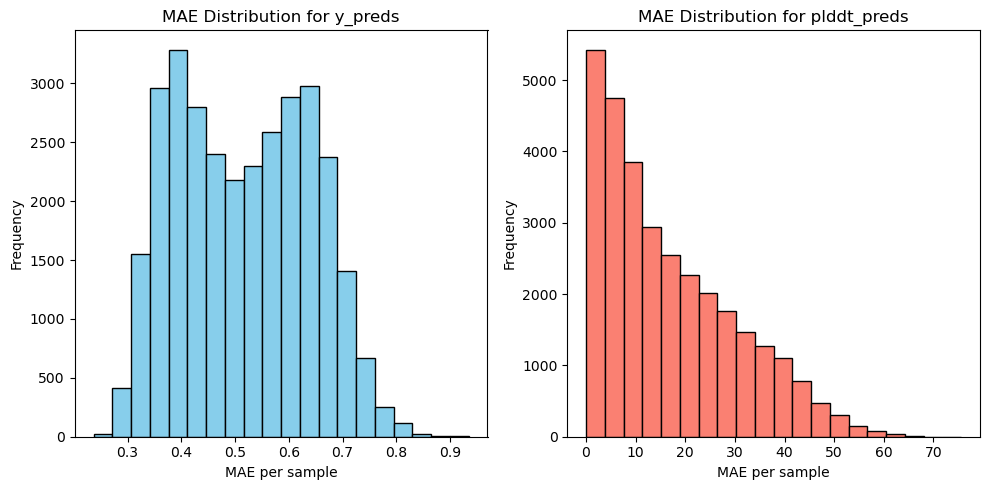

In [4]:
y_preds = tf.concat(y_preds, axis=0) #(N, 281), calculate mean absolute error 
plddt_preds = tf.concat(plddt_preds, axis=0) #(N, 1), calculate mean absolute error
seq_preds = tf.concat(seq_preds, axis=0) # (N, 21), calculate categrical crossentropy and categorical accuracy
y_trues = tf.concat(y_trues, axis=0) 
plddt_trues = tf.concat(plddt_trues, axis=0)
seq_trues = tf.concat(seq_trues, axis=0)


# --- Metrics ---
# 1. Mean Absolute Error for y_preds
mae_y_samplewise = tf.reduce_mean(tf.abs(y_preds - y_trues), axis=-1)  # per sample
mae_y = tf.reduce_mean(mae_y_samplewise)  # overall

# 2. Mean Absolute Error for plddt_preds
mae_plddt_samplewise = tf.reduce_mean(tf.abs(plddt_preds - plddt_trues), axis=-1)
mae_plddt = tf.reduce_mean(mae_plddt_samplewise)

# 3. Categorical Crossentropy for seq_preds
seq_trues_ohe = seq_trues
cce_seq = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(seq_trues_ohe, seq_preds))

# 4. Categorical Accuracy for seq_preds
acc_seq = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(seq_trues_ohe, seq_preds))

# --- Print results ---
print(f"Mean Absolute Error (y_preds): {mae_y.numpy():.4f}")
print(f"Mean Absolute Error (plddt_preds): {mae_plddt.numpy():.4f}")
print(f"Categorical Crossentropy (seq_preds): {cce_seq.numpy():.4f}")
print(f"Categorical Accuracy (seq_preds): {acc_seq.numpy():.4f}")

# --- Visualization of MAE distribution ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(mae_y_samplewise.numpy(), bins=20, color='skyblue', edgecolor='black')
plt.title("MAE Distribution for y_preds")
plt.xlabel("MAE per sample")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(mae_plddt_samplewise.numpy(), bins=20, color='salmon', edgecolor='black')
plt.title("MAE Distribution for plddt_preds")
plt.xlabel("MAE per sample")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


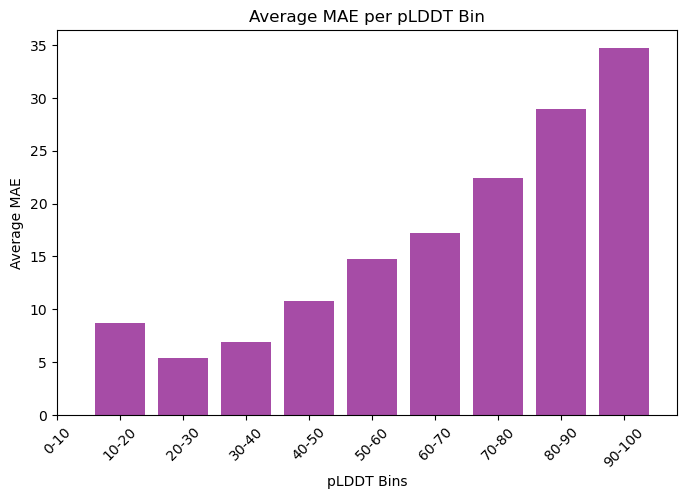


Feature-wise error stats:
              Feature  Mean Error  Stddev Error
0              sasa_N    0.188245      0.133210
1                cx_N    0.022253      0.017305
2          rd_value_N    0.059848      0.055939
3             sasa_CA    0.043086      0.037714
4               cx_CA    0.019685      0.015130
..                ...         ...           ...
276  cos_cb_k2_and_k3    0.350059      0.260846
277  cos_ca_k2_and_k4    0.300108      0.274901
278  cos_cb_k2_and_k4    0.364413      0.275411
279  cos_ca_k3_and_k4    0.315261      0.274890
280  cos_cb_k3_and_k4    0.359380      0.267592

[281 rows x 3 columns]

Amino acid accuracy/confusion table (%):
   Accuracy          A         R         N         D          C    E  \
A  0.690236  69.023569  0.000000  0.000000  0.000000   0.168350  0.0   
R  0.076043   0.000000  7.604345  0.000000  0.000000   0.000000  0.0   
N  0.000533   0.053333  0.853333  0.053333  0.853333   0.533333  0.0   
D  0.014330   0.311526  0.436137  0.186916 

In [32]:
import numpy as np
import pandas as pd
import json

with open('columns.json', 'r') as f:
    columns = json.load(f)
dim = 301
keep_indices = [i for i in range(dim) if i not in remove_set]
columns2 = [columns[i] for i in keep_indices]
# =====================================================
# 1. Bin pLDDTs into 10 bins and calculate average MAE per bin
# =====================================================
plddt_values = tf.squeeze(plddt_trues).numpy()
mae_values = mae_plddt_samplewise.numpy()
bins = np.linspace(0, 100, 11)  # 10 bins
bin_indices = np.digitize(plddt_values, bins) - 1

bin_mae = []
for i in range(len(bins)-1):
    mask = bin_indices == i
    if np.any(mask):
        bin_mae.append(mae_values[mask].mean())
    else:
        bin_mae.append(np.nan)

plt.figure(figsize=(8, 5))
plt.bar(range(10), bin_mae, width=0.8, color='purple', alpha=0.7)
plt.xticks(range(10), [f"{int(bins[i])}-{int(bins[i+1])}" for i in range(10)], rotation=45)
plt.xlabel("pLDDT Bins")
plt.ylabel("Average MAE")
plt.title("Average MAE per pLDDT Bin")
plt.show()

# =====================================================
# 2. Table: Feature-wise Mean and Stddev Error
# =====================================================
errors = tf.abs(y_preds - y_trues).numpy()  # (N, 281)
feature_stats = pd.DataFrame({
    "Feature": columns2,
    "Mean Error": errors.mean(axis=0),
    "Stddev Error": errors.std(axis=0)
})
print("\nFeature-wise error stats:")
print(feature_stats)

# =====================================================
# 3. Amino Acid Accuracy + Confusion Matrix Table
# =====================================================
aa_order = list("ARNDCEQGHILKMFPSTWYVX")  # 21 categories
true_labels = tf.argmax(seq_trues_ohe, axis=-1).numpy()
pred_labels = tf.argmax(seq_preds, axis=-1).numpy()

conf_matrix = np.zeros((21, 21), dtype=np.int32)
for t, p in zip(true_labels, pred_labels):
    conf_matrix[t, p] += 1

aa_table = []
for i, aa in enumerate(aa_order):
    total = conf_matrix[i].sum()
    acc = conf_matrix[i, i] / total if total > 0 else 0
    percentages = (conf_matrix[i] / total * 100) if total > 0 else np.zeros(21)
    aa_table.append([acc] + list(percentages))

aa_df = pd.DataFrame(aa_table, columns=["Accuracy"] + aa_order, index=aa_order)
print("\nAmino acid accuracy/confusion table (%):")
print(aa_df)

Text(0, 0.5, 'True Amino Acid')

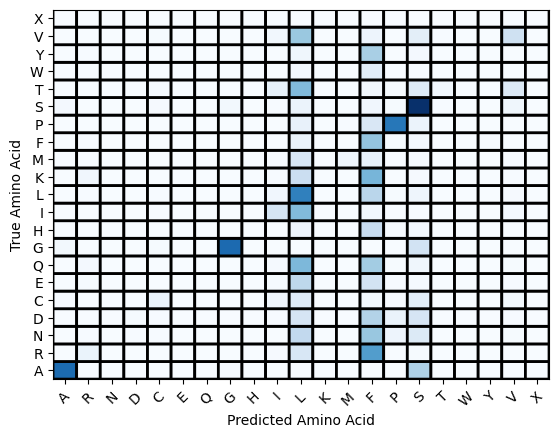

In [33]:
plt.heatmap = plt.pcolor(conf_matrix, cmap='Blues', edgecolors='k', linewidths=2)
plt.xticks(np.arange(21) + 0.5, aa_order, rotation=45)
plt.yticks(np.arange(21) + 0.5, aa_order)
plt.xlabel("Predicted Amino Acid")
plt.ylabel("True Amino Acid")

In [34]:
b = np.sum(conf_matrix, axis=1)  # Total counts per true amino acid
for a in aa_order:
    print(f"{a}: {b[aa_order.index(a)]} samples")

A: 2376 samples
R: 1749 samples
N: 1875 samples
D: 1605 samples
C: 848 samples
E: 1094 samples
Q: 1975 samples
G: 2129 samples
H: 743 samples
I: 1460 samples
L: 2345 samples
K: 1632 samples
M: 677 samples
F: 1085 samples
P: 2204 samples
S: 2602 samples
T: 1928 samples
W: 311 samples
Y: 888 samples
V: 1708 samples
X: 0 samples


In [35]:
feature_stats.to_csv('analysis/feature_stats.csv', index=False)
aa_df.to_csv('analysis/aa_accuracy_confusion.csv')


In [31]:
three_to_one = {
    'ALA': 'A',
    'ARG': 'R',
    'ASN': 'N',
    'ASP': 'D',
    'CYS': 'C',
    'GLU': 'E',
    'GLN': 'Q',
    'GLY': 'G',
    'HIS': 'H',
    'ILE': 'I',
    'LEU': 'L',
    'LYS': 'K',
    'MET': 'M',
    'PHE': 'F',
    'PRO': 'P',
    'SER': 'S',
    'THR': 'T',
    'TRP': 'W',
    'TYR': 'Y',
    'VAL': 'V',
    'UNK': '-' }

''.join(list(three_to_one.values()))

'ARNDCEQGHILKMFPSTWYV-'

# AE1 Model

In [40]:
import tensorflow as tf
import keras
from src.utils import TFRecordManager
from src.model import RandomMasking, Sampling, create_model_vae_plddt
import matplotlib.pyplot as plt

tfrecord_path = 'data/large/alphafold_db/tfrecords/repId_sim_to_2_first100.tfrecord'
tfmanager = TFRecordManager(tfrecord_path=tfrecord_path, feature_dim=301, plddt=True, batch_size=1024)
train_ds = tfmanager.read_dataset()
remove_indices = [24, 25, 34, 35, 77, 78, 87, 88, 130, 131, 140, 141, 
                  183, 184, 193, 194, 236, 237, 246, 247]
remove_set = set(remove_indices)
dim = 301
keep_indices = [i for i in range(dim) if i not in remove_set]
keep_indices_tf = tf.constant(keep_indices, dtype=tf.int32)
# load models
model = keras.models.load_model('checkpoints/ae1/best_model_epoch.keras')
decoder = keras.models.load_model('checkpoints/ae1/decoder.keras')

In [62]:
#latent 64
# outputs: decoder, plddt, seq
model.summary()

Model: "ae_plddt_seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features_input      │ (None, 281)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_masking      │ (None, 281)       │          0 │ features_input[0… │
│ (RandomMasking)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_0     │ (None, 512)       │    144,384 │ random_masking[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_1     │ (None, 256)       │    131,328 │ encoder_dense_0[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_2     │ (None, 128)       │     32,896 │ encoder_dense_1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent (Dense)      │ (None, 64)        │      8,256 │ encoder_dense_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 281)       │    317,081 │ latent[0][0]      │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ plddt_model         │ (None, 1)         │     16,641 │ latent[0][0]      │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_model           │ (None, 21)        │     22,037 │ latent[0][0]      │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,017,871 (7.70 MB)

 Trainable params: 672,623 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,345,248 (5.13 MB)

In [14]:
y_preds, plddt_preds, seq_preds = [], [], []
y_trues, plddt_trues, seq_trues = [], [], []

for i in tfmanager.read_dataset():
    x, seq, ids, plddt = i
    x = tf.gather(x, keep_indices_tf, axis=1)
    x = tf.cast(x, tf.float32)
    seq = tf.cast(seq, tf.int32)
    plddt = tf.cast(plddt / 100., tf.float32)
    seq = tf.one_hot(tf.squeeze(seq, axis=-1), depth=21, dtype=tf.float32)
    y_pred, plddt_pred, seq_pred = model.predict(x)
    y_preds.append(y_pred)
    plddt_preds.append(plddt_pred)
    seq_preds.append(seq_pred)
    y_trues.append(x)
    plddt_trues.append(plddt)
    seq_trues.append(seq)
# concatenate results
y_preds = tf.concat(y_preds, axis=0) #(N, 281), calculate mean absolute error 
plddt_preds = tf.concat(plddt_preds, axis=0) #(N, 1), calculate mean absolute error
seq_preds = tf.concat(seq_preds, axis=0) # (N, 21), calculate categrical crossentropy and categorical accuracy
y_trues = tf.concat(y_trues, axis=0)
plddt_trues = tf.concat(plddt_trues, axis=0)
seq_trues = tf.concat(seq_trues, axis=0)
# print shapes all in one line
print(f"y_preds shape: {y_preds.shape}, plddt_preds shape: {plddt_preds.shape}, seq_preds shape: {seq_preds.shape}, "
      f"y_trues shape: {y_trues.shape}, plddt_trues shape: {plddt_trues.shape}, seq_trues shape: {seq_trues.shape}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━

Mean Absolute Error (y_preds): 0.4069
Mean Absolute Error (plddt_preds): 0.1122
Categorical Crossentropy (seq_preds): 1.1633
Categorical Accuracy (seq_preds): 0.5921


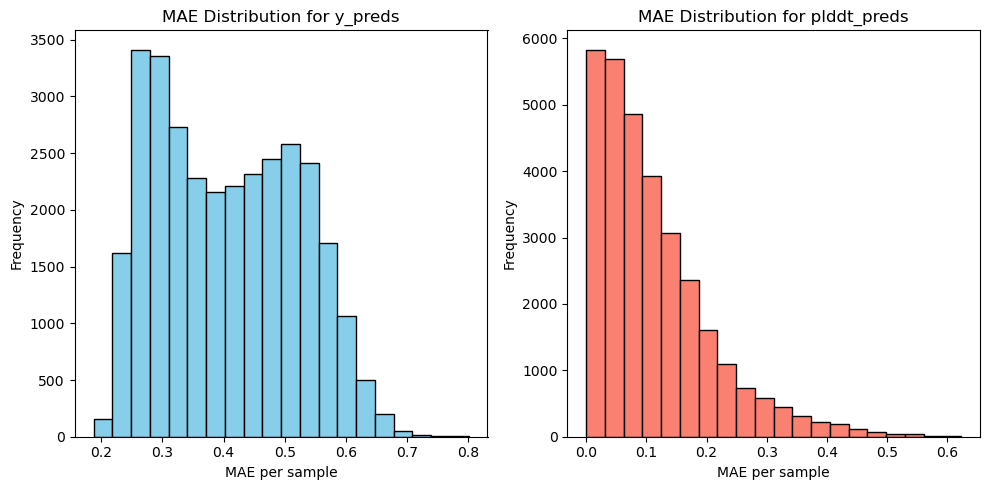

In [15]:
# --- Metrics ---
# 1. Mean Absolute Error for y_preds
mae_y_samplewise = tf.reduce_mean(tf.abs(y_preds - y_trues), axis=-1)  # per sample
mae_y = tf.reduce_mean(mae_y_samplewise)  # overall

# 2. Mean Absolute Error for plddt_preds: in this model, plddt is divided by 100 and output is in range [0, 1]
mae_plddt_samplewise = tf.reduce_mean(tf.abs(plddt_preds - plddt_trues), axis=-1)
mae_plddt = tf.reduce_mean(mae_plddt_samplewise)

# 3. Categorical Crossentropy for seq_preds
seq_trues_ohe = seq_trues
cce_seq = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(seq_trues_ohe, seq_preds))

# 4. Categorical Accuracy for seq_preds
acc_seq = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(seq_trues_ohe, seq_preds))

# --- Print results ---
print(f"Mean Absolute Error (y_preds): {mae_y.numpy():.4f}")
print(f"Mean Absolute Error (plddt_preds): {mae_plddt.numpy():.4f}")
print(f"Categorical Crossentropy (seq_preds): {cce_seq.numpy():.4f}")
print(f"Categorical Accuracy (seq_preds): {acc_seq.numpy():.4f}")

# --- Visualization of MAE distribution ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(mae_y_samplewise.numpy(), bins=20, color='skyblue', edgecolor='black')
plt.title("MAE Distribution for y_preds")
plt.xlabel("MAE per sample")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(mae_plddt_samplewise.numpy(), bins=20, color='salmon', edgecolor='black')
plt.title("MAE Distribution for plddt_preds")
plt.xlabel("MAE per sample")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

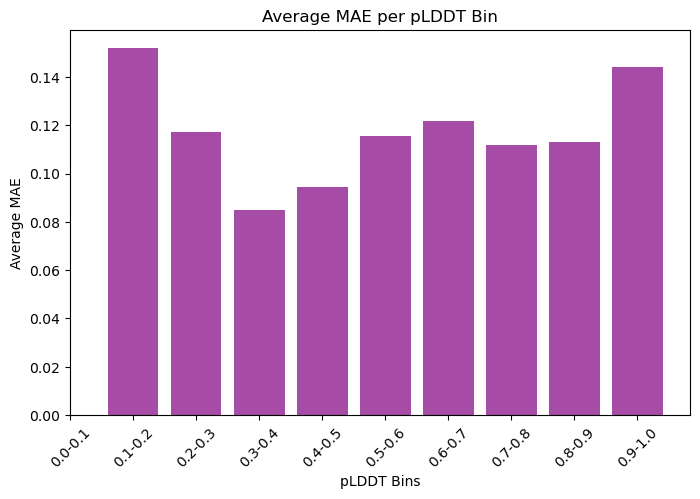


Feature-wise error stats:
              Feature  Mean Error  Stddev Error
0              sasa_N    0.184466      0.155222
1                cx_N    0.004887      0.004648
2          rd_value_N    0.041994      0.055932
3             sasa_CA    0.022272      0.018808
4               cx_CA    0.005612      0.006240
..                ...         ...           ...
276  cos_cb_k2_and_k3    0.316546      0.275352
277  cos_ca_k2_and_k4    0.301267      0.272793
278  cos_cb_k2_and_k4    0.305728      0.265982
279  cos_ca_k3_and_k4    0.302696      0.275887
280  cos_cb_k3_and_k4    0.317753      0.264838

[281 rows x 3 columns]

Amino acid accuracy/confusion table (%):
   Accuracy          A          R          N          D          C          E  \
A  0.986953  98.695286   0.000000   0.000000   0.042088   0.000000   0.000000   
R  0.788451   0.000000  78.845054   0.057176   0.000000   0.000000   7.375643   
N  0.366400   0.320000   0.586667  36.640000  14.986667   0.106667  18.026667   
D  0.33

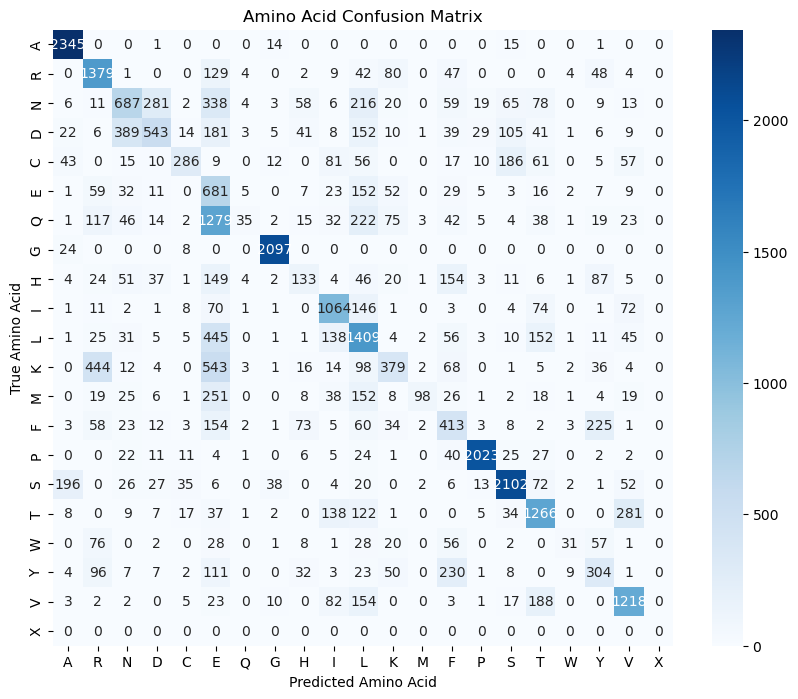

In [21]:
import numpy as np
import pandas as pd
import json

with open('columns.json', 'r') as f:
    columns = json.load(f)
dim = 301
keep_indices = [i for i in range(dim) if i not in remove_set]
columns2 = [columns[i] for i in keep_indices]
# =====================================================
# 1. Bin pLDDTs into 10 bins and calculate average MAE per bin
# =====================================================
plddt_values = tf.squeeze(plddt_trues).numpy() 
mae_values = mae_plddt_samplewise.numpy()
bins = np.linspace(0, 1, 11)  # 10 bins *****
bin_indices = np.digitize(plddt_values, bins) - 1

bin_mae = []
for i in range(len(bins)-1):
    mask = bin_indices == i
    if np.any(mask):
        bin_mae.append(mae_values[mask].mean())
    else:
        bin_mae.append(np.nan)

plt.figure(figsize=(8, 5))
plt.bar(range(10), bin_mae, width=0.8, color='purple', alpha=0.7)
plt.xticks(range(10), [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(10)], rotation=45)
plt.xlabel("pLDDT Bins")
plt.ylabel("Average MAE")
plt.title("Average MAE per pLDDT Bin")
plt.show()

# =====================================================
# 2. Table: Feature-wise Mean and Stddev Error
# =====================================================
errors = tf.abs(y_preds - y_trues).numpy()  # (N, 281)
feature_stats = pd.DataFrame({
    "Feature": columns2,
    "Mean Error": errors.mean(axis=0),
    "Stddev Error": errors.std(axis=0)
})
print("\nFeature-wise error stats:")
print(feature_stats)

# =====================================================
# 3. Amino Acid Accuracy + Confusion Matrix Table
# =====================================================
aa_order = list("ARNDCEQGHILKMFPSTWYVX")  # 21 categories
true_labels = tf.argmax(seq_trues_ohe, axis=-1).numpy()
pred_labels = tf.argmax(seq_preds, axis=-1).numpy()

conf_matrix = np.zeros((21, 21), dtype=np.int32)
for t, p in zip(true_labels, pred_labels):
    conf_matrix[t, p] += 1

aa_table = []
for i, aa in enumerate(aa_order):
    total = conf_matrix[i].sum()
    acc = conf_matrix[i, i] / total if total > 0 else 0
    percentages = (conf_matrix[i] / total * 100) if total > 0 else np.zeros(21)
    aa_table.append([acc] + list(percentages))

aa_df = pd.DataFrame(aa_table, columns=["Accuracy"] + aa_order, index=aa_order)
print("\nAmino acid accuracy/confusion table (%):")
print(aa_df)

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=aa_order, yticklabels=aa_order)
plt.xlabel("Predicted Amino Acid")
plt.ylabel("True Amino Acid")
plt.title("Amino Acid Confusion Matrix")
plt.show()

# AE2

In [ ]:
import tensorflow as tf
import keras
from src.utils import TFRecordManager
from src.model import RandomMasking, Sampling, create_model_vae_plddt
import matplotlib.pyplot as plt

tfrecord_path = 'data/large/alphafold_db/tfrecords/repId_sim_to_2_first100.tfrecord'
tfmanager = TFRecordManager(tfrecord_path=tfrecord_path, feature_dim=301, plddt=True, batch_size=1024)
train_ds = tfmanager.read_dataset()
remove_indices = [24, 25, 34, 35, 77, 78, 87, 88, 130, 131, 140, 141, 
                  183, 184, 193, 194, 236, 237, 246, 247]
remove_set = set(remove_indices)
dim = 301
keep_indices = [i for i in range(dim) if i not in remove_set]
keep_indices_tf = tf.constant(keep_indices, dtype=tf.int32)
# load models
model = keras.models.load_model('checkpoints/ae/best_model_epoch.keras')
model.summary()

Model: "ae_plddt_seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ features_input      │ (None, 281)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_masking      │ (None, 281)       │          0 │ features_input[0… │
│ (RandomMasking)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_0     │ (None, 512)       │    144,384 │ random_masking[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_1     │ (None, 256)       │    131,328 │ encoder_dense_0[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_2     │ (None, 128)       │     32,896 │ encoder_dense_1[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ latent (Dense)      │ (None, 64)        │      8,256 │ encoder_dense_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 281)       │    317,081 │ latent[0][0]      │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ plddt_model         │ (None, 1)         │     16,641 │ latent[0][0]      │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_model           │ (None, 21)        │     22,037 │ latent[0][0]      │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,017,871 (7.70 MB)

 Trainable params: 672,623 (2.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,345,248 (5.13 MB)

In [147]:
y_preds, plddt_preds, seq_preds = [], [], []
y_trues, plddt_trues, seq_trues = [], [], []

for i in tfmanager.read_dataset():
    x, seq, ids, plddt = i
    x = tf.gather(x, keep_indices_tf, axis=1)
    x = tf.cast(x, tf.float32)
    seq = tf.cast(seq, tf.int32)
    plddt = tf.cast(plddt / 100., tf.float32)
    seq = tf.one_hot(tf.squeeze(seq, axis=-1), depth=21, dtype=tf.float32)
    y_pred, plddt_pred, seq_pred = model.predict(x)
    y_preds.append(y_pred)
    plddt_preds.append(plddt_pred)
    seq_preds.append(seq_pred)
    y_trues.append(x)
    plddt_trues.append(plddt)
    seq_trues.append(seq)
# concatenate results
y_preds = tf.concat(y_preds, axis=0) #(N, 281), calculate mean absolute error 
plddt_preds = tf.concat(plddt_preds, axis=0) #(N, 1), calculate mean absolute error
seq_preds = tf.concat(seq_preds, axis=0) # (N, 21), calculate categrical crossentropy and categorical accuracy
y_trues = tf.concat(y_trues, axis=0)
plddt_trues = tf.concat(plddt_trues, axis=0)
seq_trues = tf.concat(seq_trues, axis=0)
# print shapes all in one line
print(f"y_preds shape: {y_preds.shape}, plddt_preds shape: {plddt_preds.shape}, seq_preds shape: {seq_preds.shape}, "
      f"y_trues shape: {y_trues.shape}, plddt_trues shape: {plddt_trues.shape}, seq_trues shape: {seq_trues.shape}")

32/32 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━

2025-08-11 17:27:24.606926: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Absolute Error (y_preds): 0.5310
Mean Absolute Error (plddt_preds): 0.1131
Categorical Crossentropy (seq_preds): 1.1006
Categorical Accuracy (seq_preds): 0.6216


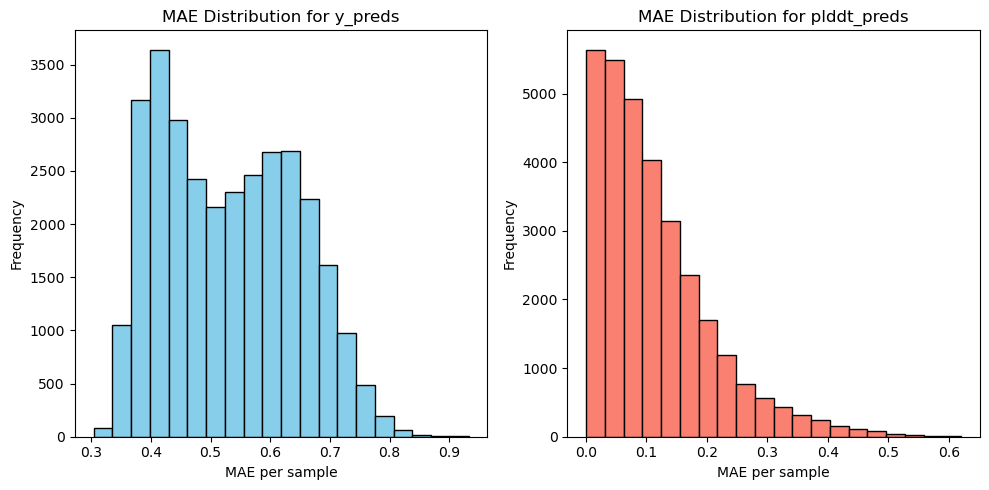

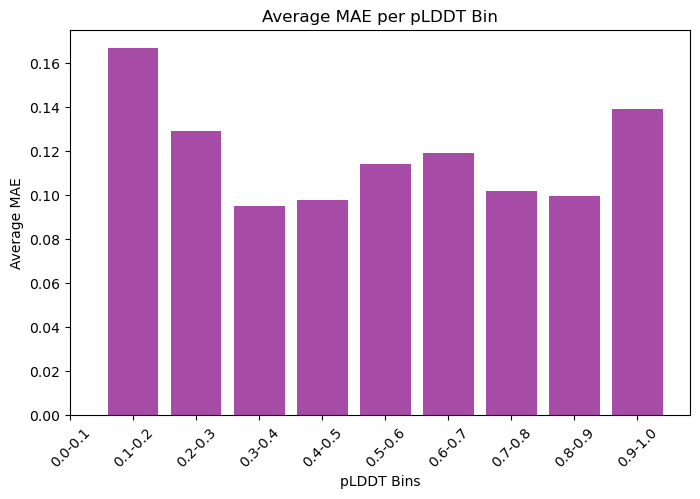


Feature-wise error stats:
              Feature  Mean Error  Stddev Error
0              sasa_N    0.166857      0.137590
1                cx_N    0.003895      0.004240
2          rd_value_N    0.047493      0.054075
3             sasa_CA    0.022098      0.018107
4               cx_CA    0.004818      0.005552
..                ...         ...           ...
276  cos_cb_k2_and_k3    0.321924      0.261086
277  cos_ca_k2_and_k4    0.285855      0.277919
278  cos_cb_k2_and_k4    0.300024      0.263642
279  cos_ca_k3_and_k4    0.305320      0.272804
280  cos_cb_k3_and_k4    0.310097      0.259140

[281 rows x 3 columns]

Amino acid accuracy/confusion table (%):
   Accuracy          A          R          N          D          C          E  \
A  0.972643  97.264310   0.000000   0.000000   0.000000   0.000000   0.000000   
R  0.742710   0.057176  74.271012   0.343053   0.057176   0.000000   1.029160   
N  0.379733   0.160000   0.373333  37.973333  22.720000   0.426667   2.026667   
D  0.40

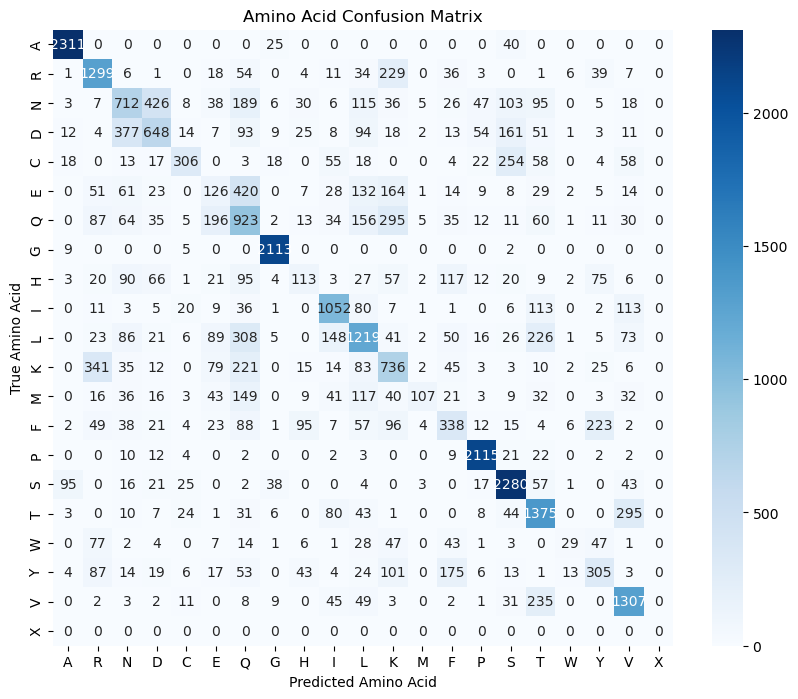

In [150]:
# --- Metrics ---
# 1. Mean Absolute Error for y_preds
mae_y_samplewise = tf.reduce_mean(tf.abs(y_preds - y_trues), axis=-1)  # per sample
mae_y = tf.reduce_mean(mae_y_samplewise)  # overall

# 2. Mean Absolute Error for plddt_preds: in this model, plddt is divided by 100 and output is in range [0, 1]
mae_plddt_samplewise = tf.reduce_mean(tf.abs(plddt_preds - plddt_trues), axis=-1)
mae_plddt = tf.reduce_mean(mae_plddt_samplewise)

# 3. Categorical Crossentropy for seq_preds
seq_trues_ohe = seq_trues
cce_seq = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(seq_trues_ohe, seq_preds))

# 4. Categorical Accuracy for seq_preds
acc_seq = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(seq_trues_ohe, seq_preds))

# --- Print results ---
print(f"Mean Absolute Error (y_preds): {mae_y.numpy():.4f}")
print(f"Mean Absolute Error (plddt_preds): {mae_plddt.numpy():.4f}")
print(f"Categorical Crossentropy (seq_preds): {cce_seq.numpy():.4f}")
print(f"Categorical Accuracy (seq_preds): {acc_seq.numpy():.4f}")

# --- Visualization of MAE distribution ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(mae_y_samplewise.numpy(), bins=20, color='skyblue', edgecolor='black')
plt.title("MAE Distribution for y_preds")
plt.xlabel("MAE per sample")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(mae_plddt_samplewise.numpy(), bins=20, color='salmon', edgecolor='black')
plt.title("MAE Distribution for plddt_preds")
plt.xlabel("MAE per sample")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


import numpy as np
import pandas as pd
import json

with open('columns.json', 'r') as f:
    columns = json.load(f)
dim = 301
keep_indices = [i for i in range(dim) if i not in remove_set]
columns2 = [columns[i] for i in keep_indices]
# =====================================================
# 1. Bin pLDDTs into 10 bins and calculate average MAE per bin
# =====================================================
plddt_values = tf.squeeze(plddt_trues).numpy() 
mae_values = mae_plddt_samplewise.numpy()
bins = np.linspace(0, 1, 11)  # 10 bins *****
bin_indices = np.digitize(plddt_values, bins) - 1

bin_mae = []
for i in range(len(bins)-1):
    mask = bin_indices == i
    if np.any(mask):
        bin_mae.append(mae_values[mask].mean())
    else:
        bin_mae.append(np.nan)

plt.figure(figsize=(8, 5))
plt.bar(range(10), bin_mae, width=0.8, color='purple', alpha=0.7)
plt.xticks(range(10), [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(10)], rotation=45)
plt.xlabel("pLDDT Bins")
plt.ylabel("Average MAE")
plt.title("Average MAE per pLDDT Bin")
plt.show()

# =====================================================
# 2. Table: Feature-wise Mean and Stddev Error
# =====================================================
errors = tf.abs(y_preds - y_trues).numpy()  # (N, 281)
feature_stats = pd.DataFrame({
    "Feature": columns2,
    "Mean Error": errors.mean(axis=0),
    "Stddev Error": errors.std(axis=0)
})
print("\nFeature-wise error stats:")
print(feature_stats)

# =====================================================
# 3. Amino Acid Accuracy + Confusion Matrix Table
# =====================================================
aa_order = list("ARNDCEQGHILKMFPSTWYVX")  # 21 categories
true_labels = tf.argmax(seq_trues_ohe, axis=-1).numpy()
pred_labels = tf.argmax(seq_preds, axis=-1).numpy()

conf_matrix = np.zeros((21, 21), dtype=np.int32)
for t, p in zip(true_labels, pred_labels):
    conf_matrix[t, p] += 1

aa_table = []
for i, aa in enumerate(aa_order):
    total = conf_matrix[i].sum()
    acc = conf_matrix[i, i] / total if total > 0 else 0
    percentages = (conf_matrix[i] / total * 100) if total > 0 else np.zeros(21)
    aa_table.append([acc] + list(percentages))

aa_df = pd.DataFrame(aa_table, columns=["Accuracy"] + aa_order, index=aa_order)
print("\nAmino acid accuracy/confusion table (%):")
print(aa_df)

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=aa_order, yticklabels=aa_order)
plt.xlabel("Predicted Amino Acid")
plt.ylabel("True Amino Acid")
plt.title("Amino Acid Confusion Matrix")
plt.show()

In [165]:
import src.constants as constants
from importlib import reload
reload(constants)
angles_pred = tf.gather(y_preds, constants.angle_columns, axis=1)
angles_true = tf.gather(y_trues, constants.angle_columns, axis=1)
for i in range(angles_pred.shape[1]):
    a = constants.angle_columns[i]
    print(f"Angle {constants.column_names[a]}: {constants.angle_columns[i]} - Pred: {tf.reduce_mean(tf.nn.tanh(angles_pred[:, i])).numpy():.4f}, +- {tf.math.reduce_std(tf.nn.tanh(angles_pred[:, i])).numpy():.4f} | True: {tf.reduce_mean(angles_true[:, i]).numpy():.4f}, +- {tf.math.reduce_std(angles_true[:, i]).numpy():.4f}")
len(constants.column_names)

Angle u27_dist_0: 32 - Pred: -0.4873, +- 0.2923 | True: -0.4592, +- 0.3015
Angle u28_dist_0: 33 - Pred: -0.1474, +- 0.4610 | True: -0.1579, +- 0.4384
Angle nearest_neighbours_ca_0: 34 - Pred: -0.0551, +- 0.5241 | True: -0.0323, +- 0.5778
Angle nearest_distances_ca_0: 35 - Pred: -0.0388, +- 0.4956 | True: -0.0216, +- 0.5513
Angle t12_cos_0: 36 - Pred: -0.7126, +- 0.0848 | True: -0.7109, +- 0.2609
Angle t23_cos_0: 37 - Pred: -0.4188, +- 0.1817 | True: -0.4803, +- 0.4015
Angle t45_cos_0: 38 - Pred: -0.5009, +- 0.1319 | True: -0.4767, +- 0.2980
Angle t56_cos_0: 39 - Pred: -0.1155, +- 0.2158 | True: -0.1360, +- 0.4492
Angle t78_cos_0: 40 - Pred: 0.4543, +- 0.4898 | True: 0.3971, +- 0.6035
Angle t89_cos_0: 41 - Pred: 0.4491, +- 0.4912 | True: 0.3976, +- 0.6018
Angle t108_cos_0: 42 - Pred: 0.3217, +- 0.3289 | True: 0.2382, +- 0.5783
Angle t811_cos_0: 43 - Pred: 0.3864, +- 0.3878 | True: 0.2862, +- 0.5585
Angle t110_cos_0: 44 - Pred: 0.3391, +- 0.3881 | True: 0.2733, +- 0.5587
Angle t311_cos_0

301

# AE3_291

In [383]:
import tensorflow as tf
import keras
from src.utils import TFRecordManager
from src.model import RandomMasking, Sampling, create_model_vae_plddt
import matplotlib.pyplot as plt
reload(constants)

tfrecord_path = 'data/large/alphafold_db/tfrecords/repId_sim_to_2_first100.tfrecord'
tfmanager = TFRecordManager(tfrecord_path=tfrecord_path, feature_dim=301, plddt=True, batch_size=1024)
train_ds = tfmanager.read_dataset()
remove_indices = constants.remove_indices_291
remove_set = set(remove_indices)
dim = 301
keep_indices = [i for i in range(dim) if i not in remove_set]
keep_indices_tf = tf.constant(keep_indices, dtype=tf.int32)
# load models
model = keras.models.load_model('checkpoints/ae3_291dim/best_model_epoch.keras')
model.summary()

y_preds, plddt_preds, seq_preds = [], [], []
y_trues, plddt_trues, seq_trues = [], [], []

for i in tfmanager.read_dataset():
    x, seq, ids, plddt = i
    x = tf.gather(x, keep_indices_tf, axis=1)
    x = tf.cast(x, tf.float32)
    seq = tf.cast(seq, tf.int32)
    plddt = tf.cast(plddt / 100., tf.float32)
    seq = tf.one_hot(tf.squeeze(seq, axis=-1), depth=21, dtype=tf.float32)
    y_pred, plddt_pred, seq_pred = model.predict(x)
    y_preds.append(y_pred)
    plddt_preds.append(plddt_pred)
    seq_preds.append(seq_pred)
    y_trues.append(x)
    plddt_trues.append(plddt)
    seq_trues.append(seq)
# concatenate results
y_preds = tf.concat(y_preds, axis=0) #(N, 281), calculate mean absolute error 
plddt_preds = tf.concat(plddt_preds, axis=0) #(N, 1), calculate mean absolute error
seq_preds = tf.concat(seq_preds, axis=0) # (N, 21), calculate categrical crossentropy and categorical accuracy
y_trues = tf.concat(y_trues, axis=0)
plddt_trues = tf.concat(plddt_trues, axis=0)
seq_trues = tf.concat(seq_trues, axis=0)
# print shapes all in one line
print(f"y_preds shape: {y_preds.shape}, plddt_preds shape: {plddt_preds.shape}, seq_preds shape: {seq_preds.shape}, "
      f"y_trues shape: {y_trues.shape}, plddt_trues shape: {plddt_trues.shape}, seq_trues shape: {seq_trues.shape}")

Model: "ae_plddt_seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inp         │ (None, 291)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_masking      │ (None, 291)       │          0 │ encoder_inp[0][0] │
│ (RandomMasking)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_0     │ (None, 128)       │     37,376 │ random_masking[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_latent      │ (None, 64)        │      8,256 │ encoder_dense_0[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 291)       │     45,859 │ encoder_latent[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ plddt_model         │ (None, 1)         │      2,113 │ encoder_latent[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_model           │ (None, 21)        │     11,029 │ encoder_latent[0… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 313,901 (1.20 MB)

 Trainable params: 104,633 (408.72 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 209,268 (817.46 KB)

32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 944us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 938us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 908us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 904us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 892us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 973us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 921us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 875us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 933us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 988us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 999us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 916us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 991us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 

Mean Absolute Error (y_preds): 0.6625
Mean Absolute Error (plddt_preds): 0.1260
Categorical Crossentropy (seq_preds): 1.5280
Categorical Accuracy (seq_preds): 0.4975


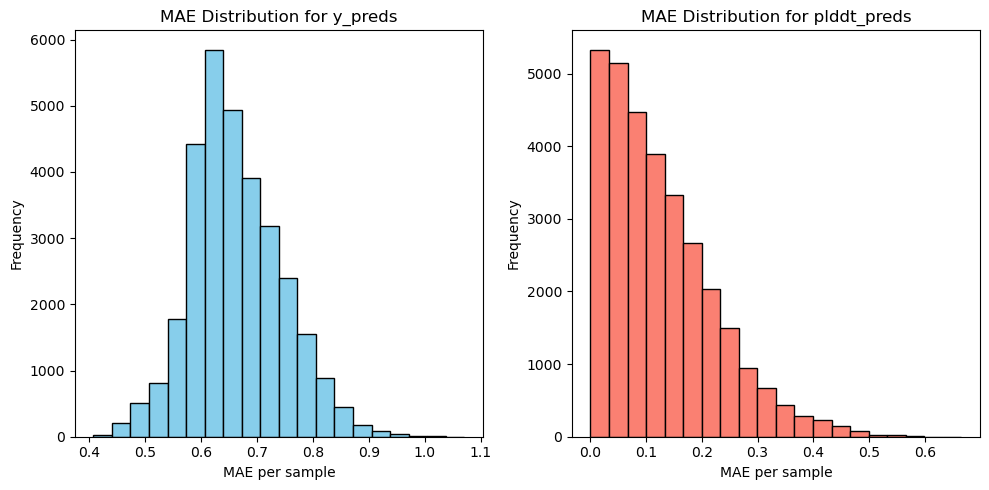

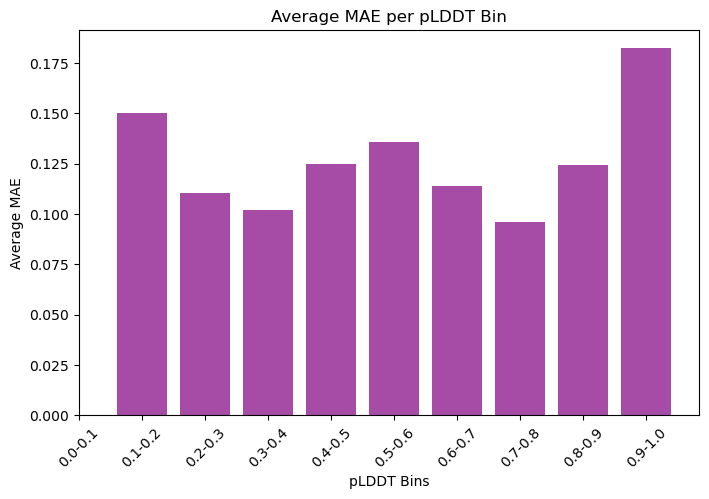


Feature-wise error stats:
              Feature  Mean Error  Stddev Error  Mean True  Stddev True  \
0              sasa_N    0.185268      0.131319   0.331968     0.250184   
1                cx_N    0.011686      0.008771   0.010548     0.007337   
2          rd_value_N    0.064733      0.063032   0.270781     0.098024   
3             sasa_CA    0.040219      0.036181   0.050768     0.066715   
4               cx_CA    0.008040      0.006106   0.010826     0.007541   
..                ...         ...           ...        ...          ...   
286  cos_cb_k2_and_k3    0.437102      0.314070  -0.081927     0.642637   
287  cos_ca_k2_and_k4    0.516050      0.401790   0.370965     0.706091   
288  cos_cb_k2_and_k4    0.537398      0.302341   0.148054     0.670737   
289  cos_ca_k3_and_k4    0.512730      0.369595  -0.124954     0.720539   
290  cos_cb_k3_and_k4    0.518395      0.311767   0.032947     0.667153   

     Max True  Min True  
0    1.074816  0.000000  
1    0.048064 -0.000

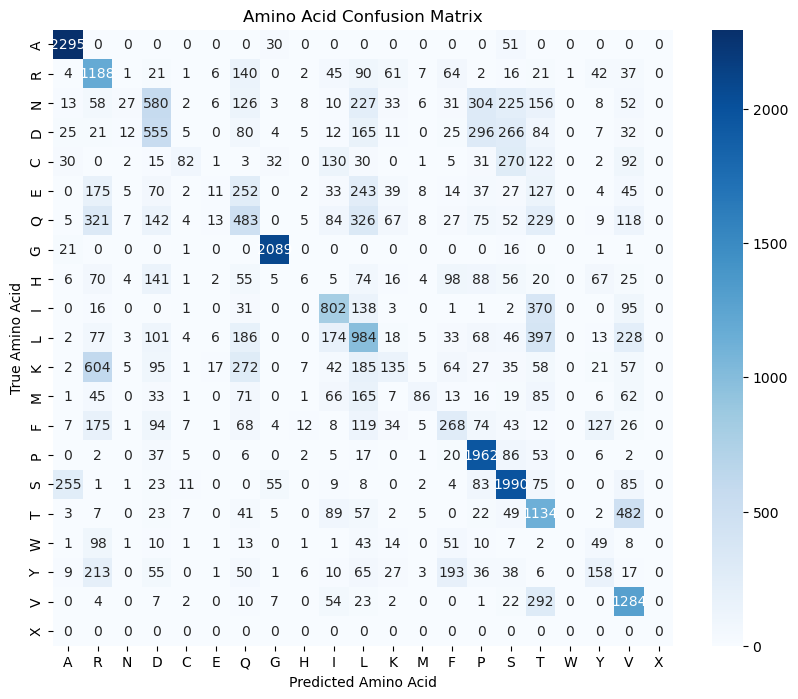

In [419]:
# --- Metrics ---
# 1. Mean Absolute Error for y_preds
mask_not_angles = np.ones_like(y_trues)
mask_not_angles[:, not_angle_columns_291] = 0. # all not angles are 0.
mask_angles = np.where(mask_not_angles == 1., 0., 1.) # all angles are zero
mae_y_featurewise_not_angles = tf.abs(y_preds - y_trues).numpy() * mask_angles #(N, d)
mae_y_featurewise_angles = tf.abs(tf.nn.tanh(y_preds) - y_trues).numpy() * mask_not_angles #(N, d)
mae_y_featurewise = mae_y_featurewise_not_angles + mae_y_featurewise_angles #(N, d)
mae_y_samplewise = tf.reduce_mean(mae_y_featurewise, axis=-1) #(N,)
del mae_y_featurewise_not_angles
del mae_y_featurewise_angles
mae_y = tf.reduce_mean(mae_y_samplewise)  # overall

# 2. Mean Absolute Error for plddt_preds: in this model, plddt is divided by 100 and output is in range [0, 1]
mae_plddt_samplewise = tf.reduce_mean(tf.abs(plddt_preds - plddt_trues), axis=-1)
mae_plddt = tf.reduce_mean(mae_plddt_samplewise)

# 3. Categorical Crossentropy for seq_preds
seq_trues_ohe = seq_trues
cce_seq = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(seq_trues_ohe, seq_preds))

# 4. Categorical Accuracy for seq_preds
acc_seq = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(seq_trues_ohe, seq_preds))

# --- Print results ---
print(f"Mean Absolute Error (y_preds): {mae_y.numpy():.4f}")
print(f"Mean Absolute Error (plddt_preds): {mae_plddt.numpy():.4f}")
print(f"Categorical Crossentropy (seq_preds): {cce_seq.numpy():.4f}")
print(f"Categorical Accuracy (seq_preds): {acc_seq.numpy():.4f}")

# --- Visualization of MAE distribution ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(mae_y_samplewise.numpy(), bins=20, color='skyblue', edgecolor='black')
plt.title("MAE Distribution for y_preds")
plt.xlabel("MAE per sample")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(mae_plddt_samplewise.numpy(), bins=20, color='salmon', edgecolor='black')
plt.title("MAE Distribution for plddt_preds")
plt.xlabel("MAE per sample")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


import numpy as np
import pandas as pd
import json

with open('columns.json', 'r') as f:
    columns = json.load(f)
dim = 301
keep_indices = [i for i in range(dim) if i not in remove_set]
columns2 = [columns[i] for i in keep_indices]
# =====================================================
# 1. Bin pLDDTs into 10 bins and calculate average MAE per bin
# =====================================================
plddt_values = tf.squeeze(plddt_trues).numpy() 
mae_values = mae_plddt_samplewise.numpy()
bins = np.linspace(0, 1, 11)  # 10 bins *****
bin_indices = np.digitize(plddt_values, bins) - 1

bin_mae = []
for i in range(len(bins)-1):
    mask = bin_indices == i
    if np.any(mask):
        bin_mae.append(mae_values[mask].mean())
    else:
        bin_mae.append(np.nan)

plt.figure(figsize=(8, 5))
plt.bar(range(10), bin_mae, width=0.8, color='purple', alpha=0.7)
plt.xticks(range(10), [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(10)], rotation=45)
plt.xlabel("pLDDT Bins")
plt.ylabel("Average MAE")
plt.title("Average MAE per pLDDT Bin")
plt.show()

# =====================================================
# 2. Table: Feature-wise Mean and Stddev Error
# =====================================================
feature_stats = pd.DataFrame({
    "Feature": columns2,
    "Mean Error": mae_y_featurewise.mean(axis=0),
    "Stddev Error": mae_y_featurewise.std(axis=0),
    "Mean True": y_trues.numpy().mean(axis=0),
    "Stddev True": y_trues.numpy().std(axis=0),
    "Max True": y_trues.numpy().max(axis=0),
    "Min True": y_trues.numpy().min(axis=0)
})
print("\nFeature-wise error stats:")
print(feature_stats)

# =====================================================
# 3. Amino Acid Accuracy + Confusion Matrix Table
# =====================================================
aa_order = list("ARNDCEQGHILKMFPSTWYVX")  # 21 categories
true_labels = tf.argmax(seq_trues_ohe, axis=-1).numpy()
pred_labels = tf.argmax(seq_preds, axis=-1).numpy()

conf_matrix = np.zeros((21, 21), dtype=np.int32)
for t, p in zip(true_labels, pred_labels):
    conf_matrix[t, p] += 1

aa_table = []
for i, aa in enumerate(aa_order):
    total = conf_matrix[i].sum()
    acc = conf_matrix[i, i] / total if total > 0 else 0
    percentages = (conf_matrix[i] / total * 100) if total > 0 else np.zeros(21)
    aa_table.append([acc] + list(percentages))

aa_df = pd.DataFrame(aa_table, columns=["Accuracy"] + aa_order, index=aa_order)
print("\nAmino acid accuracy/confusion table (%):")
print(aa_df)

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=aa_order, yticklabels=aa_order)
plt.xlabel("Predicted Amino Acid")
plt.ylabel("True Amino Acid")
plt.title("Amino Acid Confusion Matrix")
plt.show()

In [420]:
feature_stats.to_csv('analysis/feature_stats_ae3_291.csv', index=False)
aa_df.to_csv('analysis/aa_accuracy_confusion_ae3_291.csv', index=False)

In [4]:
import tensorflow as tf
import keras
from src.utils import TFRecordManager
from src.model import RandomMasking, Sampling, create_model_vae_plddt
import matplotlib.pyplot as plt
reload(constants)

tfrecord_path = 'data/large/alphafold_db/tfrecords/repId_sim_to_2_first100.tfrecord'
tfmanager = TFRecordManager(tfrecord_path=tfrecord_path, feature_dim=301, plddt=True, batch_size=1024)
train_ds = tfmanager.read_dataset()
remove_indices = constants.remove_indices_291
remove_set = set(remove_indices)
dim = 301
keep_indices = [i for i in range(dim) if i not in remove_set]
keep_indices_tf = tf.constant(keep_indices, dtype=tf.int32)
# load models
model = keras.models.load_model('checkpoints/ae4_291dim/best_model_epoch.keras')
model.summary()

y_preds, plddt_preds, seq_preds = [], [], []
y_trues, plddt_trues, seq_trues = [], [], []

for i in tfmanager.read_dataset():
    x, seq, ids, plddt = i
    x = tf.gather(x, keep_indices_tf, axis=1)
    x = tf.cast(x, tf.float32)
    seq = tf.cast(seq, tf.int32)
    plddt = tf.cast(plddt / 100., tf.float32)
    seq = tf.one_hot(tf.squeeze(seq, axis=-1), depth=21, dtype=tf.float32)
    y_pred, plddt_pred, seq_pred = model.predict(x)
    y_preds.append(y_pred)
    plddt_preds.append(plddt_pred)
    seq_preds.append(seq_pred)
    y_trues.append(x)
    plddt_trues.append(plddt)
    seq_trues.append(seq)
# concatenate results
y_preds = tf.concat(y_preds, axis=0) #(N, 281), calculate mean absolute error 
plddt_preds = tf.concat(plddt_preds, axis=0) #(N, 1), calculate mean absolute error
seq_preds = tf.concat(seq_preds, axis=0) # (N, 21), calculate categrical crossentropy and categorical accuracy
y_trues = tf.concat(y_trues, axis=0)
plddt_trues = tf.concat(plddt_trues, axis=0)
seq_trues = tf.concat(seq_trues, axis=0)
# print shapes all in one line
print(f"y_preds shape: {y_preds.shape}, plddt_preds shape: {plddt_preds.shape}, seq_preds shape: {seq_preds.shape}, "
      f"y_trues shape: {y_trues.shape}, plddt_trues shape: {plddt_trues.shape}, seq_trues shape: {seq_trues.shape}")

2025-08-14 12:56:23.286027: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Model: "ae_plddt_seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ encoder_inp         │ (None, 291)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ random_masking      │ (None, 291)       │          0 │ encoder_inp[0][0] │
│ (RandomMasking)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_dense_0     │ (None, 128)       │     37,376 │ random_masking[0… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_latent      │ (None, 128)       │     16,512 │ encoder_dense_0[… │
│ (Dense)             │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder             │ (None, 291)       │     54,051 │ encoder_latent[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ plddt_model         │ (None, 1)         │      4,161 │ encoder_latent[0… │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ seq_model           │ (None, 21)        │     19,221 │ encoder_latent[0… │
│ (Functional)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 393,965 (1.50 MB)

 Trainable params: 131,321 (512.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 262,644 (1.00 MB)

2025-08-14 12:56:23.721376: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:381] TFRecordDataset `buffer_size` is unspecified, default to 262144
I0000 00:00:1755168983.951795 3172051 service.cc:152] XLA service 0x153d00009170 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1755168983.951876 3172051 service.cc:160]   StreamExecutor device (0): Host, Default Version
2025-08-14 12:56:23.974129: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


32/32 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step   
 1/32 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step

I0000 00:00:1755168984.421372 3172051 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 937us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 983us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 966us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 940us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 950us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 935us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 952us/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 1m

2025-08-14 12:56:29.346157: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Mean Absolute Error (y_preds): 0.5956
Mean Absolute Error (plddt_preds): 0.1233
Categorical Crossentropy (seq_preds): 1.4434
Categorical Accuracy (seq_preds): 0.5236


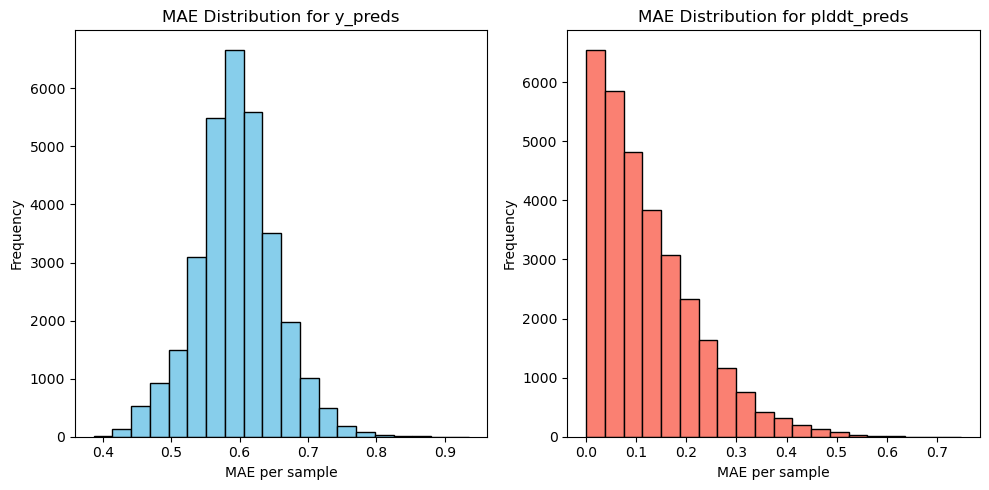

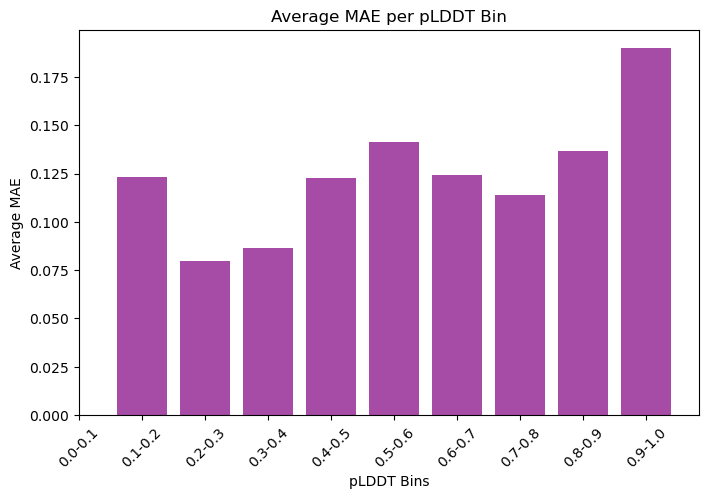


Feature-wise error stats:
              Feature  Mean Error  Stddev Error  Mean True  Stddev True  \
0              sasa_N    0.181638      0.127497   0.331968     0.250185   
1                cx_N    0.006787      0.005336   0.010548     0.007337   
2          rd_value_N    0.050388      0.059227   0.270781     0.098024   
3             sasa_CA    0.031927      0.029968   0.050768     0.066715   
4               cx_CA    0.008008      0.006266   0.010826     0.007541   
..                ...         ...           ...        ...          ...   
286  cos_cb_k2_and_k3    0.421298      0.310652  -0.081928     0.642637   
287  cos_ca_k2_and_k4    0.533158      0.381305   0.370965     0.706091   
288  cos_cb_k2_and_k4    0.561685      0.292661   0.148054     0.670737   
289  cos_ca_k3_and_k4    0.520591      0.357083  -0.124954     0.720539   
290  cos_cb_k3_and_k4    0.524107      0.304314   0.032947     0.667153   

     Max True  Min True  
0    1.074816  0.000000  
1    0.048064 -0.000

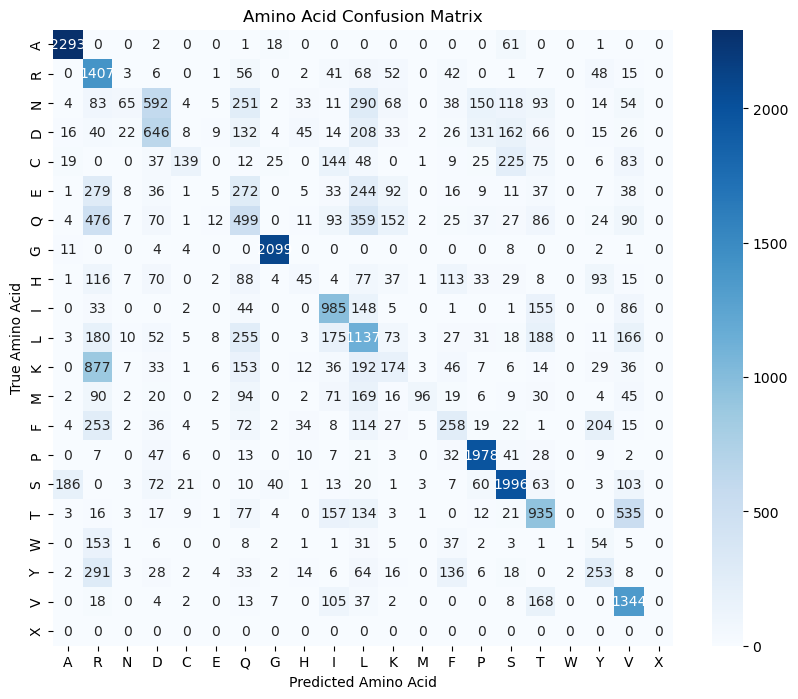

In [7]:
# --- Metrics ---
# 1. Mean Absolute Error for y_preds
mask_not_angles = np.ones_like(y_trues)
mask_not_angles[:, not_angle_columns_291] = 0. # all not angles are 0.
mask_angles = np.where(mask_not_angles == 1., 0., 1.) # all angles are zero
mae_y_featurewise_not_angles = tf.abs(y_preds - y_trues).numpy() * mask_angles #(N, d)
mae_y_featurewise_angles = tf.abs(tf.nn.tanh(y_preds) - y_trues).numpy() * mask_not_angles #(N, d)
mae_y_featurewise = mae_y_featurewise_not_angles + mae_y_featurewise_angles #(N, d)
mae_y_samplewise = tf.reduce_mean(mae_y_featurewise, axis=-1) #(N,)
del mae_y_featurewise_not_angles
del mae_y_featurewise_angles
mae_y = tf.reduce_mean(mae_y_samplewise)  # overall

# 2. Mean Absolute Error for plddt_preds: in this model, plddt is divided by 100 and output is in range [0, 1]
mae_plddt_samplewise = tf.reduce_mean(tf.abs(plddt_preds - plddt_trues), axis=-1)
mae_plddt = tf.reduce_mean(mae_plddt_samplewise)

# 3. Categorical Crossentropy for seq_preds
seq_trues_ohe = seq_trues
cce_seq = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(seq_trues_ohe, seq_preds))

# 4. Categorical Accuracy for seq_preds
acc_seq = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(seq_trues_ohe, seq_preds))

# --- Print results ---
print(f"Mean Absolute Error (y_preds): {mae_y.numpy():.4f}")
print(f"Mean Absolute Error (plddt_preds): {mae_plddt.numpy():.4f}")
print(f"Categorical Crossentropy (seq_preds): {cce_seq.numpy():.4f}")
print(f"Categorical Accuracy (seq_preds): {acc_seq.numpy():.4f}")

# --- Visualization of MAE distribution ---
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.hist(mae_y_samplewise.numpy(), bins=20, color='skyblue', edgecolor='black')
plt.title("MAE Distribution for y_preds")
plt.xlabel("MAE per sample")
plt.ylabel("Frequency")

plt.subplot(1, 2, 2)
plt.hist(mae_plddt_samplewise.numpy(), bins=20, color='salmon', edgecolor='black')
plt.title("MAE Distribution for plddt_preds")
plt.xlabel("MAE per sample")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


import numpy as np
import pandas as pd
import json

with open('columns.json', 'r') as f:
    columns = json.load(f)
dim = 301
keep_indices = [i for i in range(dim) if i not in remove_set]
columns2 = [columns[i] for i in keep_indices]
# =====================================================
# 1. Bin pLDDTs into 10 bins and calculate average MAE per bin
# =====================================================
plddt_values = tf.squeeze(plddt_trues).numpy() 
mae_values = mae_plddt_samplewise.numpy()
bins = np.linspace(0, 1, 11)  # 10 bins *****
bin_indices = np.digitize(plddt_values, bins) - 1

bin_mae = []
for i in range(len(bins)-1):
    mask = bin_indices == i
    if np.any(mask):
        bin_mae.append(mae_values[mask].mean())
    else:
        bin_mae.append(np.nan)

plt.figure(figsize=(8, 5))
plt.bar(range(10), bin_mae, width=0.8, color='purple', alpha=0.7)
plt.xticks(range(10), [f"{bins[i]:.1f}-{bins[i+1]:.1f}" for i in range(10)], rotation=45)
plt.xlabel("pLDDT Bins")
plt.ylabel("Average MAE")
plt.title("Average MAE per pLDDT Bin")
plt.show()

# =====================================================
# 2. Table: Feature-wise Mean and Stddev Error
# =====================================================
feature_stats = pd.DataFrame({
    "Feature": columns2,
    "Mean Error": mae_y_featurewise.mean(axis=0),
    "Stddev Error": mae_y_featurewise.std(axis=0),
    "Mean True": y_trues.numpy().mean(axis=0),
    "Stddev True": y_trues.numpy().std(axis=0),
    "Max True": y_trues.numpy().max(axis=0),
    "Min True": y_trues.numpy().min(axis=0)
})
print("\nFeature-wise error stats:")
print(feature_stats)

# =====================================================
# 3. Amino Acid Accuracy + Confusion Matrix Table
# =====================================================
aa_order = list("ARNDCEQGHILKMFPSTWYVX")  # 21 categories
true_labels = tf.argmax(seq_trues_ohe, axis=-1).numpy()
pred_labels = tf.argmax(seq_preds, axis=-1).numpy()

conf_matrix = np.zeros((21, 21), dtype=np.int32)
for t, p in zip(true_labels, pred_labels):
    conf_matrix[t, p] += 1

aa_table = []
for i, aa in enumerate(aa_order):
    total = conf_matrix[i].sum()
    acc = conf_matrix[i, i] / total if total > 0 else 0
    percentages = (conf_matrix[i] / total * 100) if total > 0 else np.zeros(21)
    aa_table.append([acc] + list(percentages))

aa_df = pd.DataFrame(aa_table, columns=["Accuracy"] + aa_order, index=aa_order)
print("\nAmino acid accuracy/confusion table (%):")
print(aa_df)

import seaborn as sns
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=aa_order, yticklabels=aa_order)
plt.xlabel("Predicted Amino Acid")
plt.ylabel("True Amino Acid")
plt.title("Amino Acid Confusion Matrix")
plt.show()

In [ ]:
remove_indices_291 = [24, 34,77, 87, 130, 140, 
                  183, 193, 236, 246]
remove_set_291 = remove_indices_291
keep_indices_291 = [i for i in range(301) if i not in remove_set_291]
column_names_291 = [constants.column_names[i] for i in keep_indices_291]
angle_columns_291 = {}
for i, cn in enumerate(column_names_291):
    if '_cos' in cn or '_sin' in cn: 
        angle_columns_291[cn] = i
cos_sine_columns_291 = {}
for i, cn in enumerate(column_names_291):
    if 'dihedral_cos_' in cn:
        assert column_names_291[i].replace('_cos', '') == column_names_291[i+1].replace('_sin', ''), (column_names_291[i], column_names_291[i+1])
        cos_sine_columns_291[cn+'/'+column_names_291[i+1]] = [i, i+1]
not_angle_columns_291 = {}
for i, cn in enumerate(column_names_291):
    if '_cos' in cn or '_sin' in cn:
        continue 
    else:    
        not_angle_columns_291[cn] = i


remove_indices_281 = [24, 25, 34, 35, 77, 78, 87, 88, 130, 131, 140, 141, 
                  183, 184, 193, 194, 236, 237, 246, 247]
remove_set_281 = remove_indices_281
keep_indices_281 = [i for i in range(301) if i not in remove_set_281]
column_names_281 = [constants.column_names[i] for i in keep_indices_281]
angle_columns_281 = {}
for i, cn in enumerate(column_names_281):
    if '_cos' in cn or '_sin' in cn: 
        angle_columns_281[cn] = i
cos_sine_columns_281 = {}
for i, cn in enumerate(column_names_281):
    if 'dihedral_cos_' in cn:
        assert column_names_281[i].replace('_cos', '') == column_names_281[i+1].replace('_sin', ''), (column_names_281[i], column_names_281[i+1])
        cos_sine_columns_281[cn+'/'+column_names_281[i+1]] = [i, i+1]
not_angle_columns_281 = {}
for i, cn in enumerate(column_names_281):
    if '_cos' in cn or '_sin' in cn:
        continue 
    else:    
        not_angle_columns_281[cn] = i

(145,)

# Feature Importance Analysis

In [8]:
from sklearn.metrics import f1_score
# 2. Mean Absolute Error for plddt_preds: in this model, plddt is divided by 100 and output is in range [0, 1]
mae_plddt_samplewise = tf.reduce_mean(tf.abs(plddt_preds - plddt_trues), axis=-1)
mae_plddt = tf.reduce_mean(mae_plddt_samplewise)
# 3. Categorical Crossentropy for seq_preds
seq_trues_ohe = seq_trues
cce_seq = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(seq_trues_ohe, seq_preds))
# 4. Categorical Accuracy for seq_preds
acc_seq = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(seq_trues_ohe, seq_preds))
# 5. F1 score
f1_seq = f1_score(seq_trues_ohe.numpy().argmax(axis=1), seq_preds.numpy().argmax(axis=1), average='weighted')

In [9]:
importance = {}
column_names_291 = constants.column_names_291
for i, name in enumerate(column_names_291):
    X_test_perm = y_trues.numpy().copy()
    X_test_perm[:, i] = 0.
    y_pred_perm, plddt_pred_perm, seq_pred_perm = model.predict(X_test_perm)
    mae_plddt_perm = tf.reduce_mean(tf.abs(plddt_pred_perm - plddt_trues))
    cce_seq_perm = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(seq_trues_ohe, seq_pred_perm))
    acc_seq_perm = tf.reduce_mean(tf.keras.metrics.categorical_accuracy(seq_trues_ohe, seq_pred_perm))
    f1_score_perm = f1_score(seq_trues_ohe.numpy().argmax(axis=1), seq_pred_perm.argmax(axis=1), average='weighted')
    
    importance[name] = [
        mae_plddt_perm - mae_plddt,           # higher is worse
        cce_seq_perm - cce_seq,
        acc_seq - acc_seq_perm,               # for metrics where higher is better, you subtract
        f1_seq - f1_score_perm
    ]

977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 793us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 769us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 759us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 770us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 975us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 739us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 844us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 825us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 921us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 835us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 777us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 860us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 961us/step
977/977 ━━━━━━━━━━━━━━━━━━━━ 1s 941us/step
977/977 ━━━━━━━━━━━━━━━

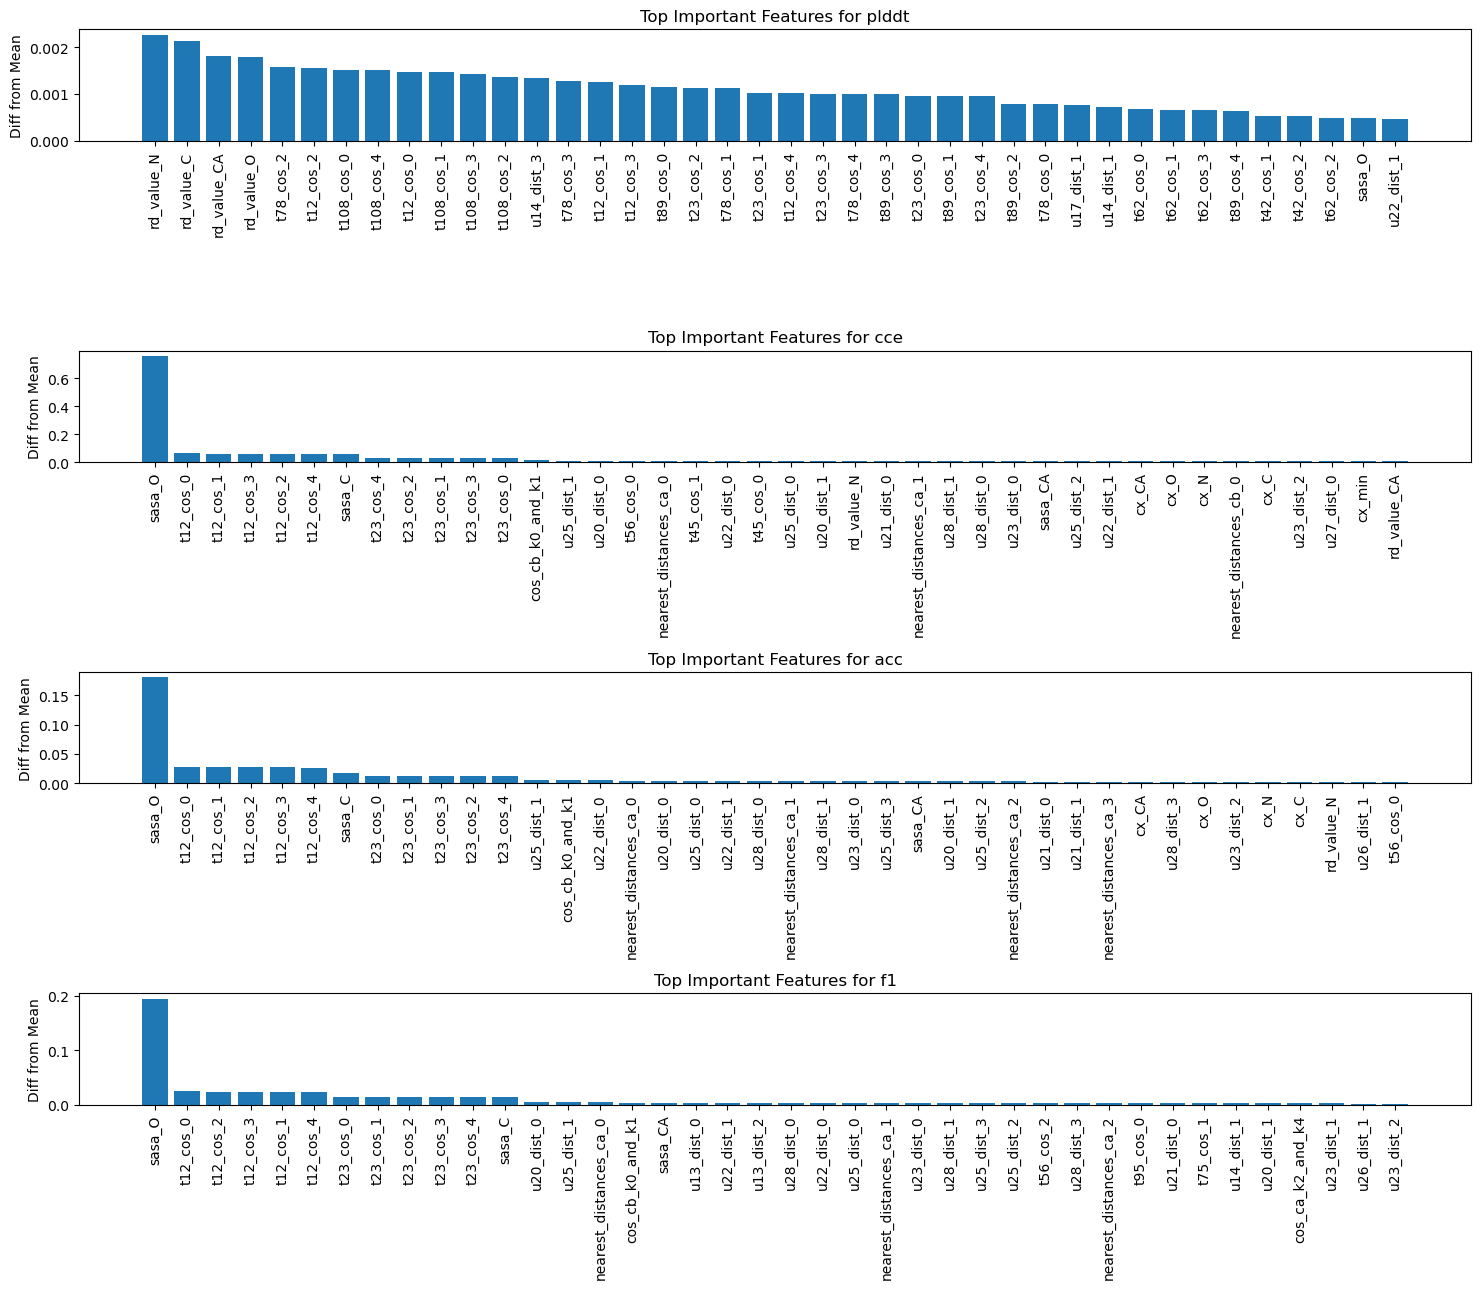

In [14]:
IMP = {}
for key, value in importance.items():
    V = []
    for v in value:
        try:
            V.append(float(v.numpy()))
        except:
            V.append(float(v))
    IMP[key] = V
IMP = pd.DataFrame(IMP)
IMP.index = ['plddt', 'cce', 'acc', 'f1']
IMP.to_csv('analysis/feature_importance.csv')
import matplotlib.pyplot as plt


fig, axes = plt.subplots(nrows=4, figsize=(15, 13))

for i, (idx, row) in enumerate(IMP.iterrows()):
    # Get top 10 lowest columns
    lowest_cols = row.nlargest(40)
    # Plot as bar
    axes[i].bar(lowest_cols.index, lowest_cols.values)
    axes[i].set_title(f"Top Important Features for {idx}")
    axes[i].set_ylabel("Diff from Mean")
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

Top 10 features affecting plddt: ['u22_dist_0', 'u26_dist_0', 'nearest_distances_cb_0', 'nearest_distances_cb_1', 'u27_dist_0', 'u21_dist_0', 'nearest_distances_ca_1', 'u25_dist_1', 'dihedral_cos_selfai_selfbi_selfbj_selfaj_0', 'u26_dist_1']
Top 10 features affecting sequence prediction: ['sasa_O', 't23_cos_0', 't23_cos_2', 't23_cos_3', 't23_cos_4', 't23_cos_1', 'sasa_C', 't45_cos_1', 't12_cos_0', 't12_cos_1']


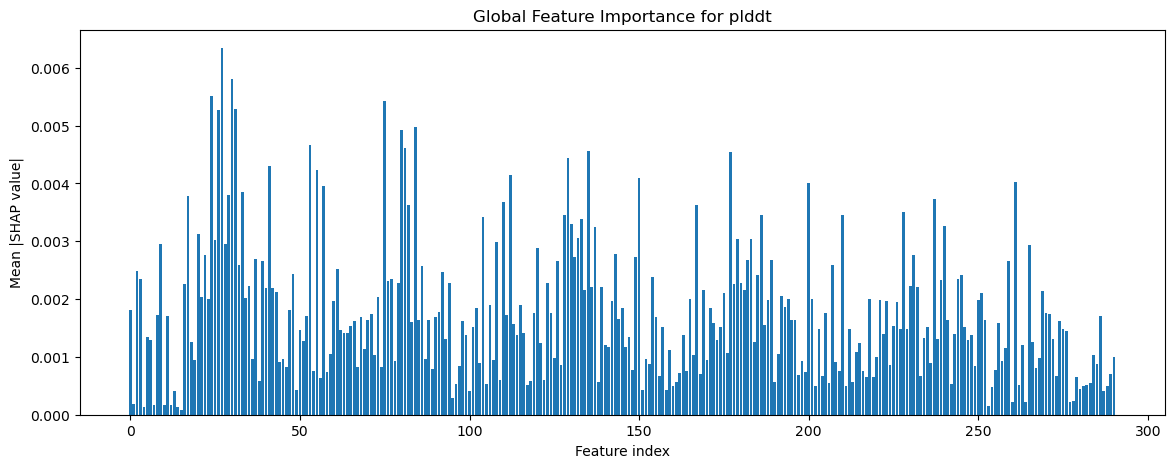

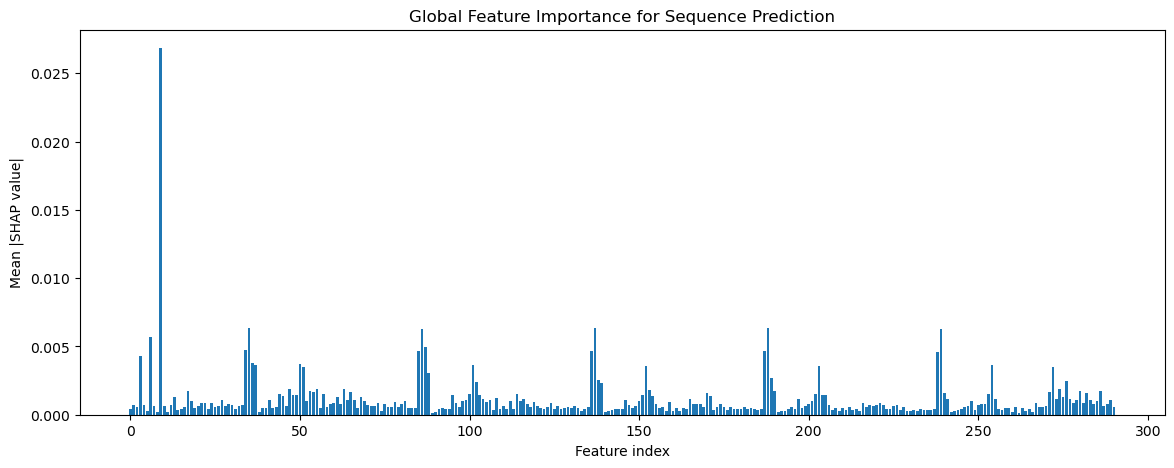

In [15]:
import shap
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from src.constants import column_names_291

# Use your input features 
X_test = y_trues.numpy().copy() # y_trues are the same as x_trues, because it is an autoencoder
samples = X_test[np.random.choice(X_test.shape[0], 100, replace=False)]
background, X_test_subset = samples[:50], samples[50:]

# Single-output models
model_plddt = keras.Model(model.input, model.output[1])
model_seq = keras.Model(model.input, model.output[2])

# --- Output 1: plddt ---
explainer_plddt = shap.GradientExplainer(model_plddt, background)
shap_plddt = explainer_plddt.shap_values(X_test_subset)
importance_plddt = np.mean(np.abs(shap_plddt), axis=0).flatten()  # shape (291,)
top10_plddt_idx = np.argsort(importance_plddt)[-10:][::-1]
top10_plddt_features = [column_names_291[i] for i in top10_plddt_idx]
print("Top 10 features affecting plddt:", top10_plddt_features)

# --- Output 2: sequence prediction ---
explainer_seq = shap.GradientExplainer(model_seq, background)
shap_seq = explainer_seq.shap_values(X_test_subset)
# shap_seq.shape = (50, 291, 21)
shap_seq_avg = np.mean(np.abs(shap_seq), axis=2)  # average over 21 classes → shape (50, 291)
importance_seq = np.mean(shap_seq_avg, axis=0)    # mean over 50 samples → shape (291,)
top10_seq_idx = np.argsort(importance_seq)[-10:][::-1]
top10_seq_features = [column_names_291[i] for i in top10_seq_idx]
print("Top 10 features affecting sequence prediction:", top10_seq_features)

# --- Plot ---
plt.figure(figsize=(14,5))
plt.bar(range(291), importance_plddt)
plt.title("Global Feature Importance for plddt")
plt.xlabel("Feature index")
plt.ylabel("Mean |SHAP value|")
plt.show()

plt.figure(figsize=(14,5))
plt.bar(range(291), importance_seq)
plt.title("Global Feature Importance for Sequence Prediction")
plt.xlabel("Feature index")
plt.ylabel("Mean |SHAP value|")
plt.show()


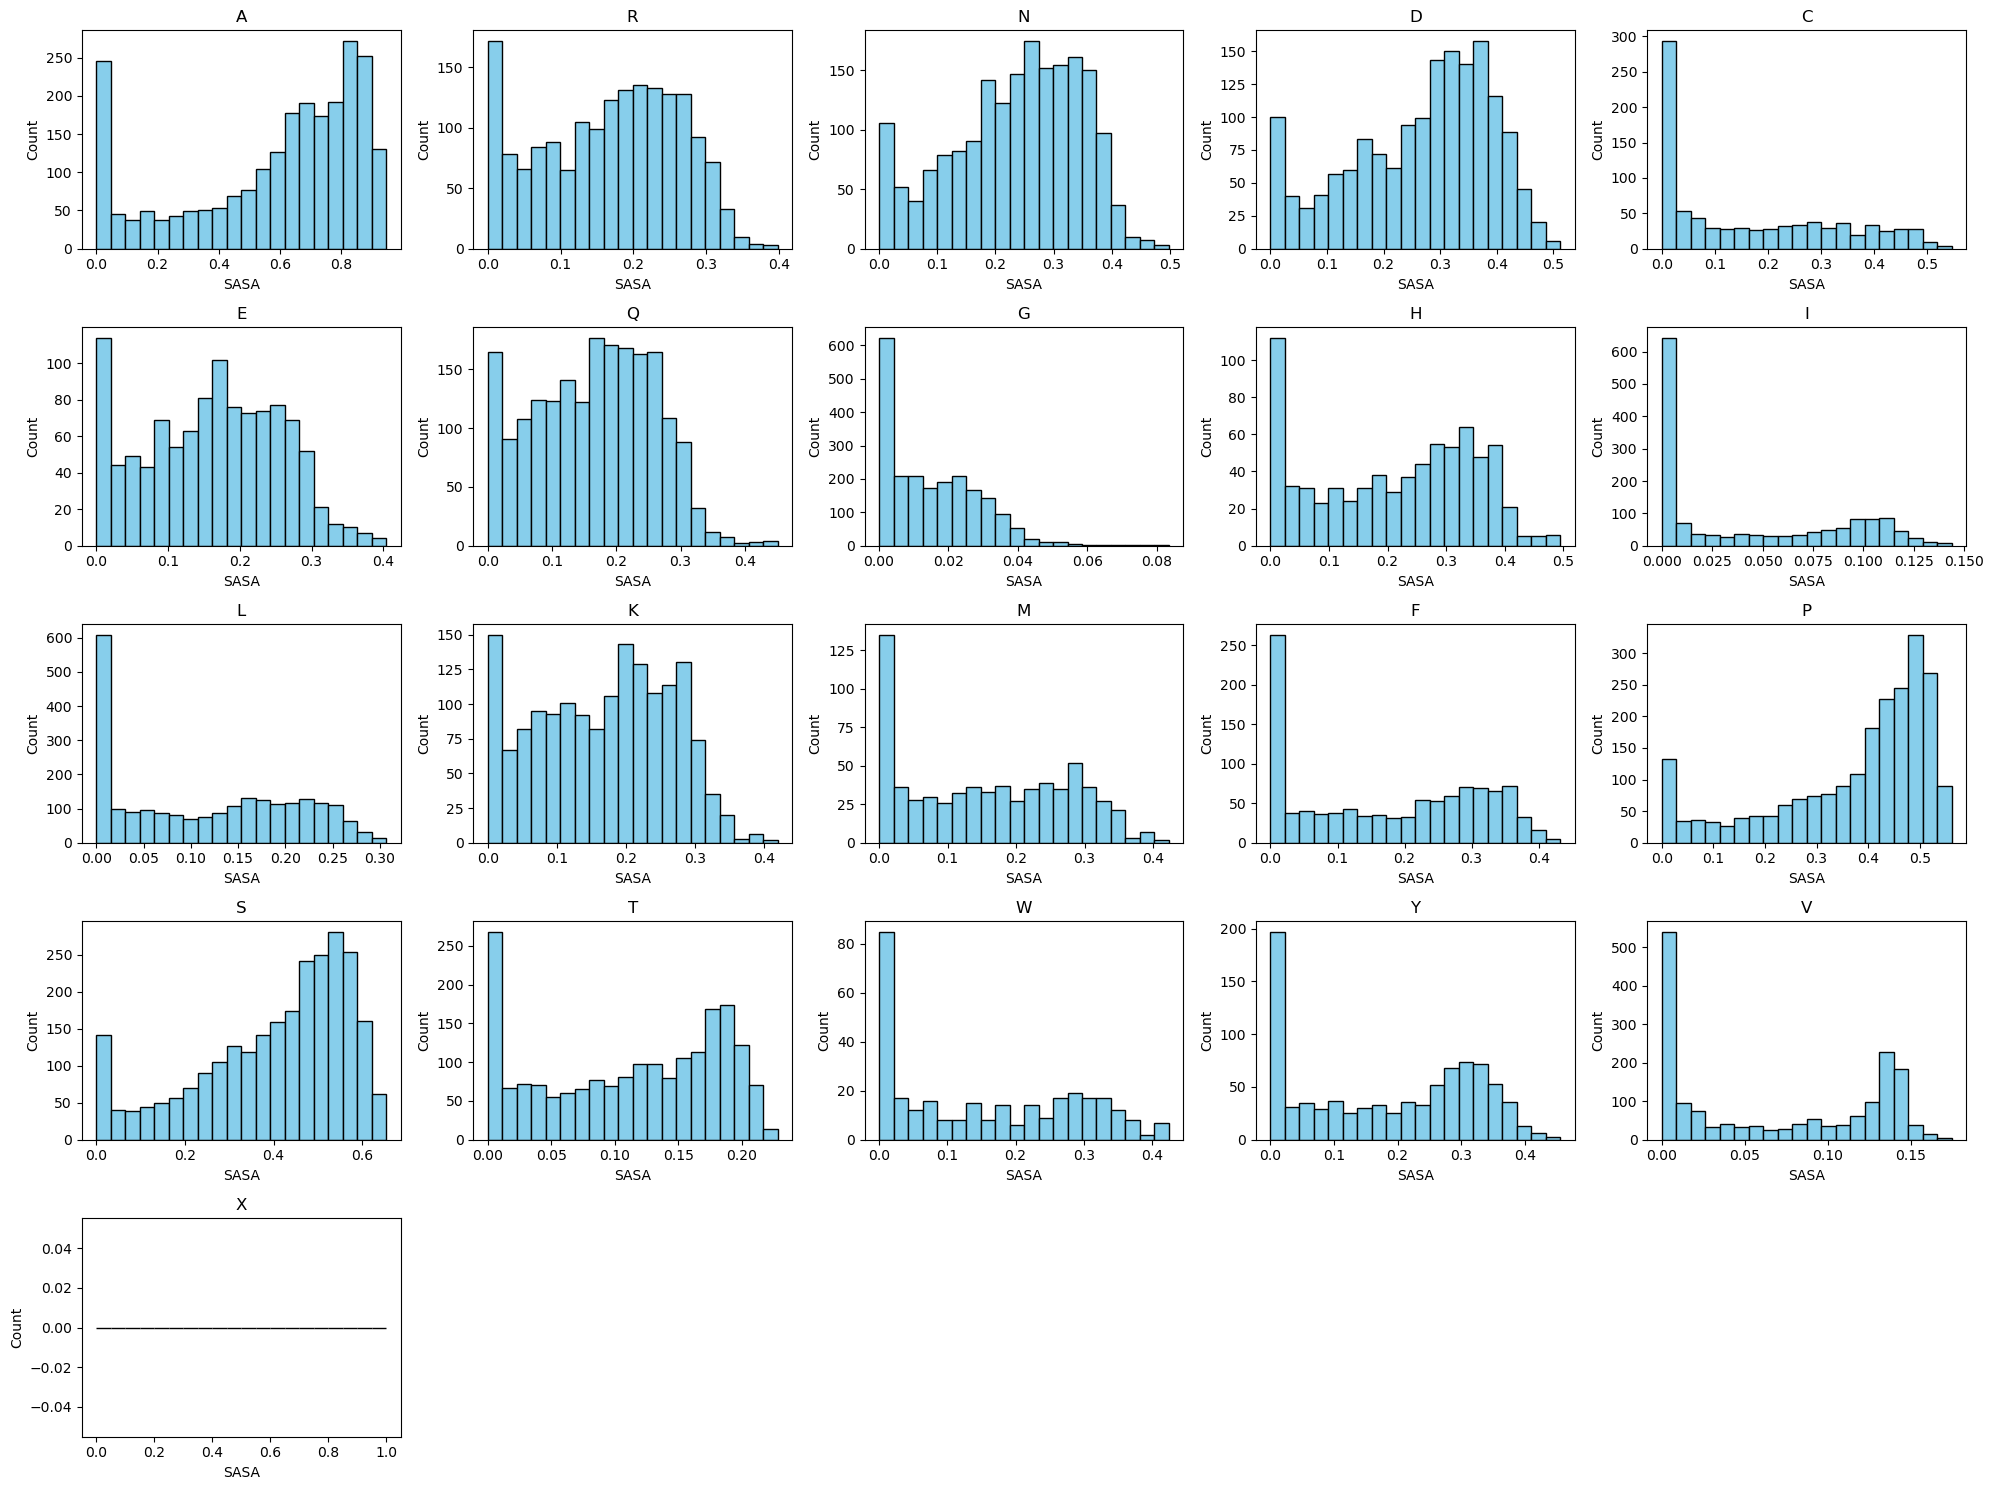

In [27]:
# look into sasa_o of different amino acids
import matplotlib.pyplot as plt
import math
X_ca_o = y_trues.numpy()[:, 9]
seq_trues_scalar = seq_trues_ohe.numpy().argmax(axis=-1)
SASAs = {}
for aa in aa_order:
    SASAs[aa] = []
for i in range(X_ca_o.shape[0]):
    aa = aa_order[int(seq_trues_scalar[i])]
    SASAs[aa].append(X_ca_o[i])


# Number of amino acids
aa_list = list(SASAs.keys())
n_aa = len(aa_list)

# Decide on subplot grid size
n_cols = 5  # for example
n_rows = math.ceil(n_aa / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*4, n_rows*3))
axes = axes.flatten()  # flatten in case we have multiple rows

for i, aa in enumerate(aa_list):
    axes[i].hist(SASAs[aa], bins=20, color='skyblue', edgecolor='black')
    axes[i].set_title(aa)
    axes[i].set_xlabel("SASA")
    axes[i].set_ylabel("Count")

# Turn off any extra empty subplots
for j in range(i+1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()

In [22]:
# --- For plddt ---
df_plddt = pd.DataFrame({
    "feature": column_names_291,
    "importance": importance_plddt
})
df_plddt.set_index("feature", inplace=True)
df_plddt = df_plddt.sort_values(by="importance", ascending=False)
print(df_plddt.head(10))  # top 10 features

# --- For sequence prediction ---
df_seq = pd.DataFrame({
    "feature": column_names_291,
    "importance": importance_seq
})
df_seq.set_index("feature", inplace=True)
df_seq = df_seq.sort_values(by="importance", ascending=False)
print(df_seq.head(10))  # top 10 features

# --- Optional: save to CSV ---
df_plddt.to_csv("analysis/importance_plddt.csv")
df_seq.to_csv("analysis/importance_seq.csv")

                                            importance
feature                                               
u26_dist_0                                    0.007454
u22_dist_0                                    0.006933
u27_dist_0                                    0.006228
dihedral_cos_selfai_selfbi_selfbj_selfaj_0    0.005748
u21_dist_0                                    0.005433
t75_cos_3                                     0.004887
t811_cos_0                                    0.004874
nearest_distances_cb_1                        0.004852
nearest_distances_cb_0                        0.004744
u26_dist_1                                    0.004731
           importance
feature              
sasa_O       0.027996
t23_cos_0    0.007152
t23_cos_4    0.007147
t23_cos_3    0.007132
t23_cos_2    0.007131
t23_cos_1    0.007113
sasa_CA      0.005456
sasa_C       0.004976
t12_cos_0    0.004339
t45_cos_1    0.004337
